In [1]:
# Eng/Amr Mostafa Omar
# Nile University ,Cairo, Egypt
# Data 7/7/2024

In [2]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
from matplotlib import colors
import time

##**Determinstic Environment (Noise=0)**

In [ ]:
class Grid_world_Env_Deterministic(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, grid_size=(9, 10), start=(2, 2), goal=(2, 8), blocked_cells=[
                                 (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9),
                                 (1, 0), (1, 6), (1, 9),
                                 (2, 0), (2, 4), (2, 9),
                                 (3, 0), (3, 4), (3, 5), (3, 9),
                                 (4, 0), (4, 4), (4, 5), (4, 9),
                                 (5, 0), (5, 9),
                                 (6, 0), (6, 9),
                                 (7, 0), (7, 9),
                                 (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9)], noise=0):
        super(Grid_world_Env_Deterministic, self).__init__()

        self.grid_size = grid_size
        self.start = start
        self.goal = goal
        self.blocked_cells = blocked_cells
        self.noise = noise
        self.current_position = start

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((spaces.Discrete(grid_size[0]), spaces.Discrete(grid_size[1])))

        self.rewards = np.full(grid_size, 0)  # Reward for each step
        self.rewards[goal] = 10  # Goal state reward
        for cell in blocked_cells:
            self.rewards[cell] = -5  # Blocked cells penalty

    def reset(self):
        self.current_position = self.start
        return self.current_position

    def is_valid_state(self, x, y):
        return 0 <= x < self.grid_size[0] and 0 <= y < self.grid_size[1] and (x, y) not in self.blocked_cells

    def step(self, action):
        if np.random.rand() < self.noise:
            action = np.random.choice([0, 1, 2, 3])

        x, y = self.current_position
        new_x, new_y = x, y
        if action == 0:  # Up
            new_x -= 1
        elif action == 1:  # Right
            new_y += 1
        elif action == 2:  # Left
            new_y -= 1
        elif action == 3:  # Down
            new_x += 1

        if not self.is_valid_state(new_x, new_y):
            new_x, new_y = x, y
            reward = -5  # Small penalty for invalid move
        else:
            reward = self.rewards[new_x, new_y]

        done = (new_x, new_y) == self.goal
        self.current_position = (new_x, new_y)
        return (new_x, new_y), reward, done, {}

    def render(self, mode='human'):
        grid_copy = np.full(self.grid_size, 0)
        grid_copy[self.goal] = 10
        for cell in self.blocked_cells:
            grid_copy[cell] = -5

        cmap = colors.ListedColormap(['black', 'white', 'green'])
        bounds = [-5.1, -0.9, 0.1, 10.1]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        plt.imshow(grid_copy, cmap=cmap, norm=norm, interpolation='nearest')

        agent_x, agent_y = self.current_position
        plt.scatter(agent_y, agent_x, c='blue', s=200, marker='*', label='Agent')
        plt.legend()
        plt.show()

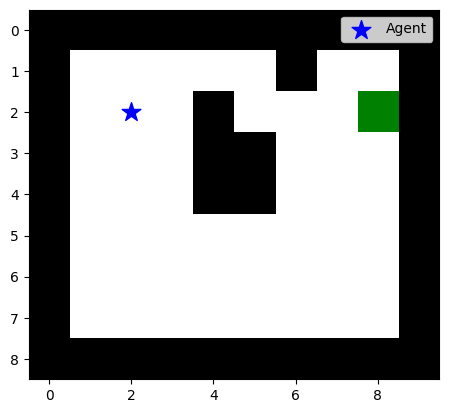

Start Position: (2, 2)


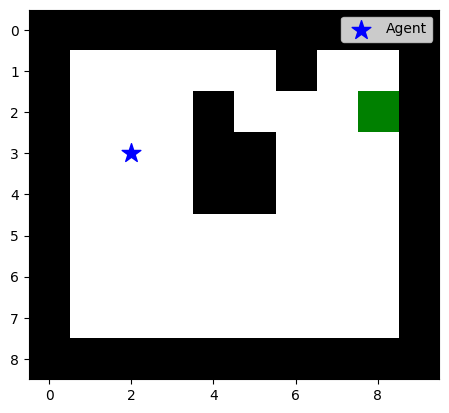

Action: 3, Next State: (3, 2), Reward: 0, Done: False


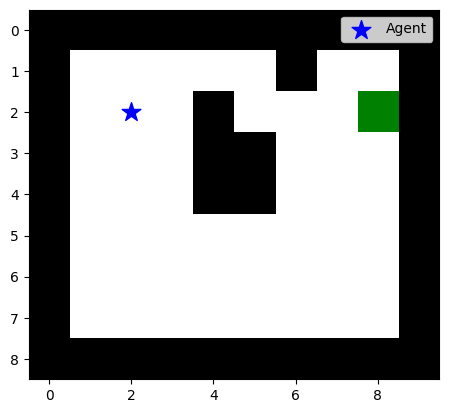

Action: 0, Next State: (2, 2), Reward: 0, Done: False


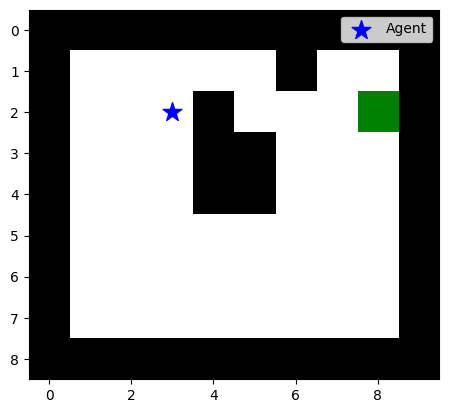

Action: 1, Next State: (2, 3), Reward: 0, Done: False


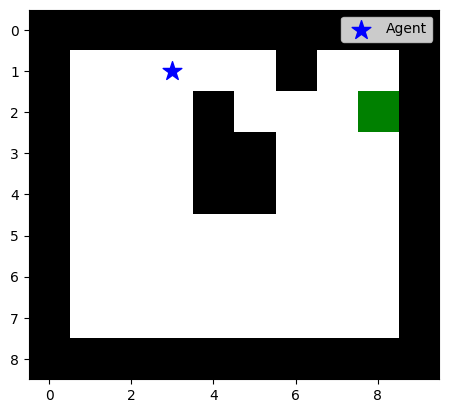

Action: 0, Next State: (1, 3), Reward: 0, Done: False


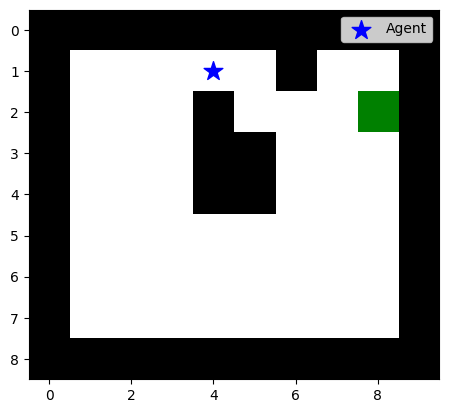

Action: 1, Next State: (1, 4), Reward: 0, Done: False


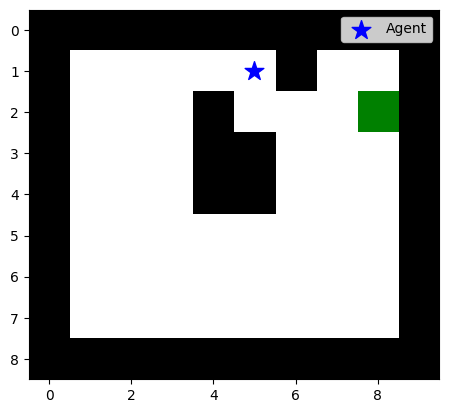

Action: 1, Next State: (1, 5), Reward: 0, Done: False


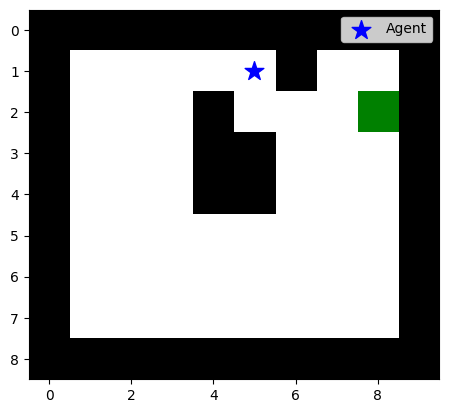

Action: 0, Next State: (1, 5), Reward: -5, Done: False


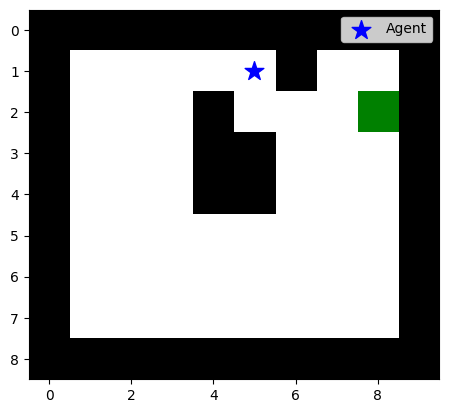

Action: 0, Next State: (1, 5), Reward: -5, Done: False


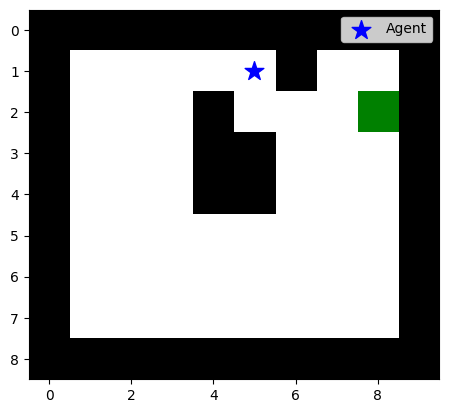

Action: 0, Next State: (1, 5), Reward: -5, Done: False


In [ ]:
# Initialize the environment
env = Grid_world_Env_Deterministic()

# Reset the environment to start the agent at the start position
state = env.reset()
env.render()
print(f"Start Position: {state}")
done = False

# Run one episode, up to 10 actions
num_actions = 0
while not done and num_actions < 9:
    action = np.random.choice([0, 1, 2, 3])  # Random action
    next_state, reward, done, info = env.step(action)
    env.render()
    print(f"Action: {action}, Next State: {next_state}, Reward: {reward}, Done: {done}")
    num_actions += 1

# **I: Implementing the Sarsa algorithm**

**Description of Sarsa Algorithm (On-policy control for estimating $Q \approx q^*$):**

**Algorithm parameters**: step size $\alpha \in (0, 1]$, small $\epsilon > 0$

- Initialize $Q(s,a)$ arbitrarily except that $Q(terminal,\cdot\;) = 0$

- Loop for each episode:

    - Initialize $S$

    - Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)
  
    - Loop for each step of episode:

        1. Take action $A$, observe $R$, $S^\prime$
        2. Choose $A^\prime$ from $S^\prime$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)
        3. $Q(S, A)  = Q(S, A) + \alpha * (R + \gamma Q(S^\prime, A^\prime) - Q(S, A))$
        4. $S = S^\prime$, $A = A^\prime$ until S is terminal

In [ ]:
class SARSAgent:
    def __init__(self, env, num_episodes=1000, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.01):
        self.env = env
        self.num_episodes = num_episodes
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = np.zeros((env.grid_size[0], env.grid_size[1], env.action_space.n))
        self.num_steps = 0

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # Exploration
        return np.argmax(self.q_table[state[0], state[1]])  # Exploitation

    def learn(self):
        start_time = time.time()
        rewards, steps_per_episode = [], []
        for episode in range(self.num_episodes):
            state = self.env.reset()
            action = self.choose_action(state)
            done, episode_reward = False, 0
            self.num_steps = 0

            while not done:
                next_state, reward, done, _ = self.env.step(action)
                next_action = self.choose_action(next_state)
                self.q_table[state[0], state[1], action] += self.alpha * (
                        reward + self.gamma * self.q_table[next_state[0], next_state[1], next_action] - self.q_table[state[0], state[1], action])
                state, action = next_state, next_action
                episode_reward += reward
                self.num_steps += 1

            rewards.append(episode_reward)
            steps_per_episode.append(self.num_steps)
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

        learning_time = time.time() - start_time
        return rewards, steps_per_episode, learning_time

    def evaluate_policy(self):
        state = self.env.reset()
        trajectory, done = [state], False
        while not done:
            action = np.argmax(self.q_table[state[0], state[1]])
            state, _, done, _ = self.env.step(action)
            trajectory.append(state)
        return trajectory

    def print_state_values(self):
        print("State Values:")
        for i in range(self.env.grid_size[0]):
            for j in range(self.env.grid_size[1]):
                print(f"{np.max(self.q_table[i, j]):.2f}", end="\t")
            print()

    def print_optimal_policy(self):
        print("Optimal Policy:")
        actions = ['U', 'R', 'L', 'D']
        for i in range(self.env.grid_size[0]):
            for j in range(self.env.grid_size[1]):
                if (i, j) == self.env.goal:
                    print("Goal", end="\t")
                elif (i, j) in self.env.blocked_cells:
                    print("X", end="\t")
                else:
                    print(actions[np.argmax(self.q_table[i, j])], end="\t")
            print()

In [ ]:
# Environment setup
env = Grid_world_Env_Deterministic()

# Initialize agent
agent = SARSAgent(env)

# Train the agent
agent.learn()

# Evaluate the learned policy and get trajectory
trajectory = agent.evaluate_policy()

rewards, steps_per_episode, learning_time = agent.learn()
print(f"Learning time: {learning_time:.2f} seconds")

# Print number of steps taken
print(f"Number of steps taken: {len(trajectory) - 1}")

# Print state values and optimal policy in matrix format
print("\nState Values (V(s)):")
agent.print_state_values()
print("\nPolicy (π(s)):")
agent.print_optimal_policy()

# Print trajectory
print("\nTrajectory of agent using optimal policy:")
for step, state in enumerate(trajectory):
    print(f"Step {step}: State {state}")

Learning time: 0.10 seconds
Number of steps taken: 14

State Values (V(s)):
State Values:
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
0.00	-1.60	-0.56	-1.97	-1.33	-0.45	0.00	0.45	5.22	0.00	
0.00	0.73	2.45	0.38	0.00	-0.51	3.11	9.48	0.00	0.00	
0.00	0.44	2.75	1.01	0.00	0.00	6.47	9.00	10.00	0.00	
0.00	0.20	3.09	1.77	0.00	0.00	5.12	8.10	8.91	0.00	
0.00	0.67	3.45	3.85	3.08	2.03	5.67	7.29	5.89	0.00	
0.00	-1.23	1.99	4.29	4.77	5.31	5.90	6.56	2.13	0.00	
0.00	-1.21	-0.89	0.87	0.52	2.73	2.25	3.32	-0.68	0.00	
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	

Policy (π(s)):
Optimal Policy:
X	X	X	X	X	X	X	X	X	X	
X	R	D	D	L	D	X	D	D	X	
X	R	D	L	X	R	R	R	Goal	X	
X	R	D	L	X	X	R	R	U	X	
X	R	D	D	X	X	R	U	U	X	
X	R	R	D	D	R	R	U	U	X	
X	R	R	R	R	R	R	U	U	X	
X	R	U	U	U	U	U	U	L	X	
X	X	X	X	X	X	X	X	X	X	

Trajectory of agent using optimal policy:
Step 0: State (2, 2)
Step 1: State (3, 2)
Step 2: State (4, 2)
Step 3: State (5, 2)
Step 4: State (5, 3)
Step 5: State (6, 3)
Step 6: State (6, 4)
Step 7: State (6, 5)
Step 

# **II: Implementing the Q-learning algorithm**

**Description of Q-learning Algorithm (Off-policy control for estimating $Q \approx q^*$):**

**Algorithm parameters**: step size $\alpha \in (0, 1]$, small $\epsilon > 0$

- Initialize $Q(s,a)$ arbitrarily except that $Q(terminal,\cdot\;) = 0$

- Loop for each episode:

    - Initialize $S$
  
    - Loop for each step of episode:

        1. Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)
        2. Take action $A$, observe $R$, $S^\prime$.
        3. $Q(S, A)  = Q(S, A) + \alpha * (R + \gamma \underset{a}{\rm max}Q(S^\prime, A^\prime) - Q(S, A))$
        4. $S = S^\prime$, $A = A^\prime$ until S is terminal

In [ ]:
class QLearningAgent:
    def __init__(self, env, num_episodes=1000, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.01):
        self.env = env
        self.num_episodes = num_episodes
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = np.zeros((env.grid_size[0], env.grid_size[1], env.action_space.n))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # Exploration
        return np.argmax(self.q_table[state[0], state[1]])  # Exploitation

    def learn(self):
        start_time = time.time()
        rewards, steps_per_episode = [], []
        for episode in range(self.num_episodes):
            state = self.env.reset()
            done, episode_reward = False, 0
            self.num_steps = 0

            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                best_next_action = np.argmax(self.q_table[next_state[0], next_state[1]])
                self.q_table[state[0], state[1], action] += self.alpha * (
                        reward + self.gamma * self.q_table[next_state[0], next_state[1], best_next_action] - self.q_table[state[0], state[1], action])
                state = next_state
                episode_reward += reward
                self.num_steps += 1

            rewards.append(episode_reward)
            steps_per_episode.append(self.num_steps)
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

        learning_time = time.time() - start_time
        return rewards, steps_per_episode, learning_time

    def evaluate_policy(self):
        state = self.env.reset()
        trajectory, done = [state], False
        while not done:
            action = np.argmax(self.q_table[state[0], state[1]])
            state, _, done, _ = self.env.step(action)
            trajectory.append(state)
        return trajectory

    def print_state_values(self):
        print("State Values:")
        for i in range(self.env.grid_size[0]):
            for j in range(self.env.grid_size[1]):
                print(f"{np.max(self.q_table[i, j]):.2f}", end="\t")
            print()

    def print_optimal_policy(self):
        print("Optimal Policy:")
        actions = ['U', 'R', 'L', 'D']
        for i in range(self.env.grid_size[0]):
            for j in range(self.env.grid_size[1]):
                if (i, j) == self.env.goal:
                    print("Goal", end="\t")
                elif (i, j) in self.env.blocked_cells:
                    print("X", end="\t")
                else:
                    print(actions[np.argmax(self.q_table[i, j])], end="\t")
            print()

In [ ]:
# Environment setup
env = Grid_world_Env_Deterministic()

# Initialize agent
agent = QLearningAgent(env)

# Train the agent
agent.learn()

rewards, steps_per_episode, learning_time = agent.learn()
print(f"Learning time: {learning_time:.2f} seconds")

# Evaluate the learned policy and get trajectory
trajectory = agent.evaluate_policy()

# Print number of steps taken
print(f"Number of steps taken: {len(trajectory) - 1}")

# Print state values and optimal policy in matrix format
print("\nState Values (V(s)):")
agent.print_state_values()
print("\nPolicy (π(s)):")
agent.print_optimal_policy()

# Print trajectory
print("\nTrajectory of agent using optimal policy:")
for step, state in enumerate(trajectory):
    print(f"Step {step}: State {state}")

Learning time: 0.08 seconds
Number of steps taken: 8

State Values (V(s)):
State Values:
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
0.00	4.41	5.31	5.90	6.56	7.29	0.00	8.58	1.90	0.00	
0.00	3.77	4.78	5.27	0.00	8.10	9.00	10.00	0.00	0.00	
0.00	0.05	3.42	1.60	0.00	0.00	7.85	8.51	6.86	0.00	
0.00	0.00	0.12	0.13	0.00	0.00	1.34	0.96	2.77	0.00	
0.00	0.00	0.00	0.00	0.00	0.00	0.08	0.13	0.48	0.00	
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.02	0.00	
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	

Policy (π(s)):
Optimal Policy:
X	X	X	X	X	X	X	X	X	X	
X	R	R	R	R	D	X	D	D	X	
X	R	U	U	X	R	R	R	Goal	X	
X	R	U	U	X	X	U	U	U	X	
X	U	U	U	X	X	U	U	U	X	
X	U	U	U	L	R	U	U	U	X	
X	R	R	U	U	U	L	U	U	X	
X	U	R	U	L	L	U	R	U	X	
X	X	X	X	X	X	X	X	X	X	

Trajectory of agent using optimal policy:
Step 0: State (2, 2)
Step 1: State (1, 2)
Step 2: State (1, 3)
Step 3: State (1, 4)
Step 4: State (1, 5)
Step 5: State (2, 5)
Step 6: State (2, 6)
Step 7: State (2, 7)
Step 8: State (2

##**Visualization paths taken by the agent using both algorithms**




In [ ]:
def render_trajectory(agent, trajectory):
    grid_copy = np.full(agent.env.grid_size, 0)
    grid_copy[agent.env.goal] = 10
    for cell in agent.env.blocked_cells:
        grid_copy[cell] = -5

    cmap = colors.ListedColormap(['black', 'white', 'green'])
    bounds = [-5.1, -0.9, 0.1, 10.1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(8, 6))
    plt.imshow(grid_copy, cmap=cmap, norm=norm, interpolation='nearest')

    start_x, start_y = agent.env.start
    plt.scatter(start_y, start_x, c='red', s=200, marker='o', label='Start')
    goal_x, goal_y = agent.env.goal
    plt.scatter(goal_y, goal_x, c='green', s=200, marker='o', label='Goal')

    for step, state in enumerate(trajectory):
        plt.scatter(state[1], state[0], c='blue', s=100, marker='*')

    plt.legend()
    plt.title('Agent Trajectory on Grid World Environment')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

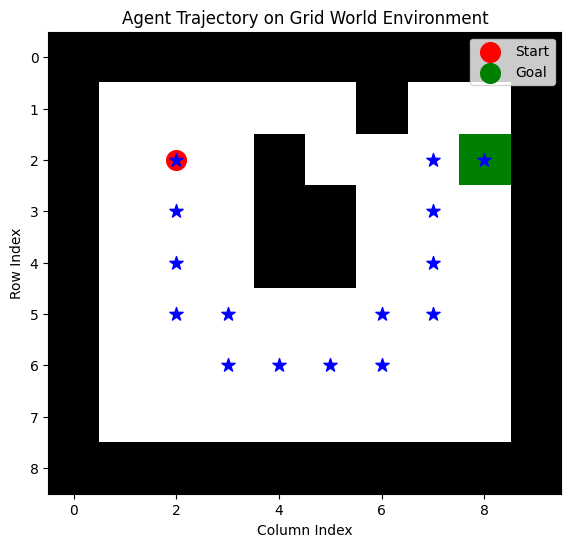

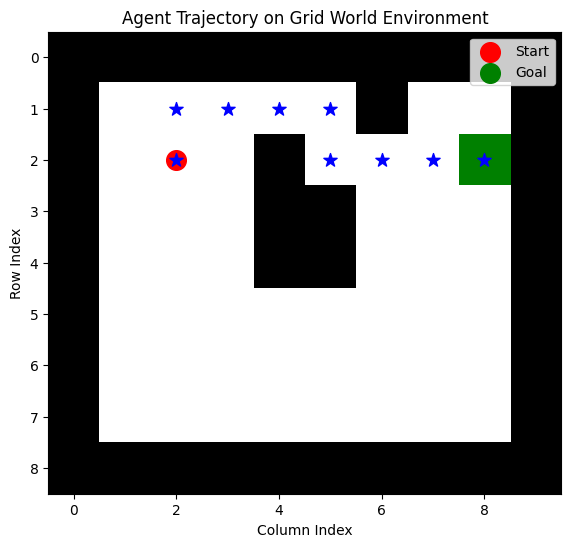

In [ ]:
agent_sarsa = SARSAgent(env)
agent_qlearning = QLearningAgent(env)

# Train the agents
agent_sarsa.learn()
agent_qlearning.learn()

# Evaluate policies and render trajectories
trajectory_sarsa = agent_sarsa.evaluate_policy()
render_trajectory(agent_sarsa, trajectory_sarsa)

trajectory_qlearning = agent_qlearning.evaluate_policy()
render_trajectory(agent_qlearning, trajectory_qlearning)

##**Analysis for both algorithms by different epsilon values**

In [ ]:
def run_experiments(env_class, agent_class, epsilon_values, num_episodes=1000):
    avg_rewards, avg_steps, all_rewards, all_steps, all_trajectories = [], [], [], [], []

    for epsilon in epsilon_values:
        env = env_class()
        agent = agent_class(env, num_episodes=num_episodes, epsilon=epsilon)
        rewards, steps, _ = agent.learn()

        avg_rewards.append(np.mean(rewards))
        avg_steps.append(np.mean(steps))
        all_rewards.append(rewards)
        all_steps.append(steps)
        trajectory = agent.evaluate_policy()
        all_trajectories.append(trajectory)

    return avg_rewards, avg_steps, all_rewards, all_steps, all_trajectories

def plot_results(avg_rewards_sarsa, avg_steps_sarsa, avg_rewards_qlearning, avg_steps_qlearning, epsilon_values):
    plt.figure(figsize=(12, 8))
    plt.plot(epsilon_values, avg_rewards_sarsa, marker='o', label='SARSA')
    plt.plot(epsilon_values, avg_rewards_qlearning, marker='o', label='Q-learning')
    plt.xlabel('Epsilon Value')
    plt.ylabel('Average Reward')
    plt.title('Average Rewards vs Epsilon Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.plot(epsilon_values, avg_steps_sarsa, marker='o', label='SARSA')
    plt.plot(epsilon_values, avg_steps_qlearning, marker='o', label='Q-learning')
    plt.xlabel('Epsilon Value')
    plt.ylabel('Average Steps')
    plt.title('Average Steps vs Epsilon Value')
    plt.legend()
    plt.show()

def render_trajectory(agent, trajectory, epsilon, algorithm, ax):
    grid_copy = np.full(agent.env.grid_size, 0)
    grid_copy[agent.env.goal] = 10
    for cell in agent.env.blocked_cells:
        grid_copy[cell] = -5

    cmap = colors.ListedColormap(['black', 'white', 'green'])
    bounds = [-5.1, -0.9, 0.1, 10.1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    ax.imshow(grid_copy, cmap=cmap, norm=norm, interpolation='nearest')

    start_x, start_y = agent.env.start
    ax.scatter(start_y, start_x, c='red', s=200, marker='o', label='Start')
    goal_x, goal_y = agent.env.goal
    ax.scatter(goal_y, goal_x, c='green', s=200, marker='o', label='Goal')

    for step, state in enumerate(trajectory):
        if step == 0:
            ax.scatter(state[1], state[0], c='blue', s=100, marker='*', label='Agent Path')
        else:
            ax.scatter(state[1], state[0], c='blue', s=100, marker='*')

    ax.legend()
    ax.set_title(f'{algorithm} Trajectory (Epsilon: {epsilon})')
    ax.set_xlabel('Column Index')
    ax.set_ylabel('Row Index')

    return trajectory

In [ ]:
epsilon_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

avg_rewards_sarsa, avg_steps_sarsa, all_rewards_sarsa, all_steps_sarsa, all_trajectories_sarsa = run_experiments(Grid_world_Env_Deterministic, SARSAgent, epsilon_values, num_episodes=1000)
avg_rewards_qlearning, avg_steps_qlearning, all_rewards_qlearning, all_steps_qlearning, all_trajectories_qlearning = run_experiments(Grid_world_Env_Deterministic, QLearningAgent, epsilon_values, num_episodes=1000)


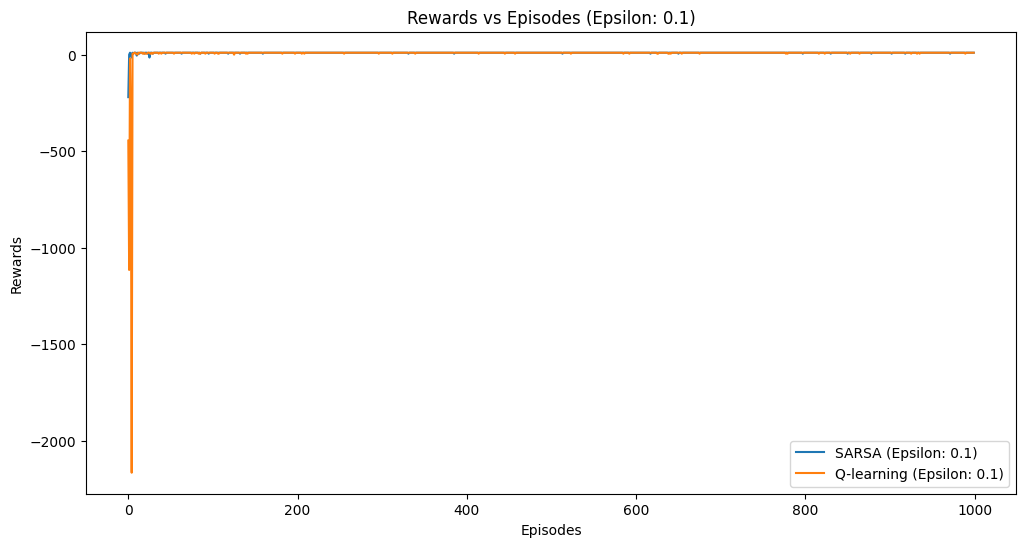

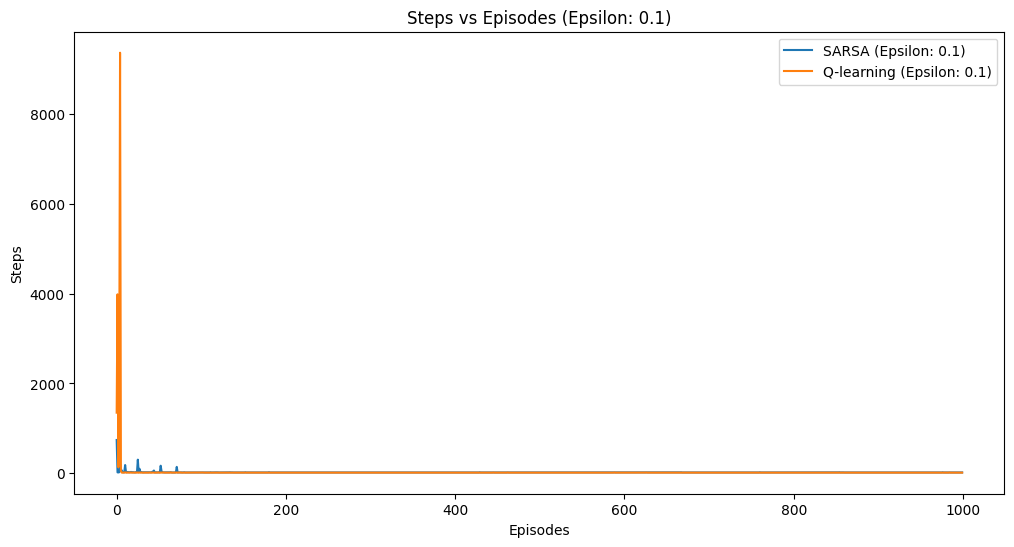

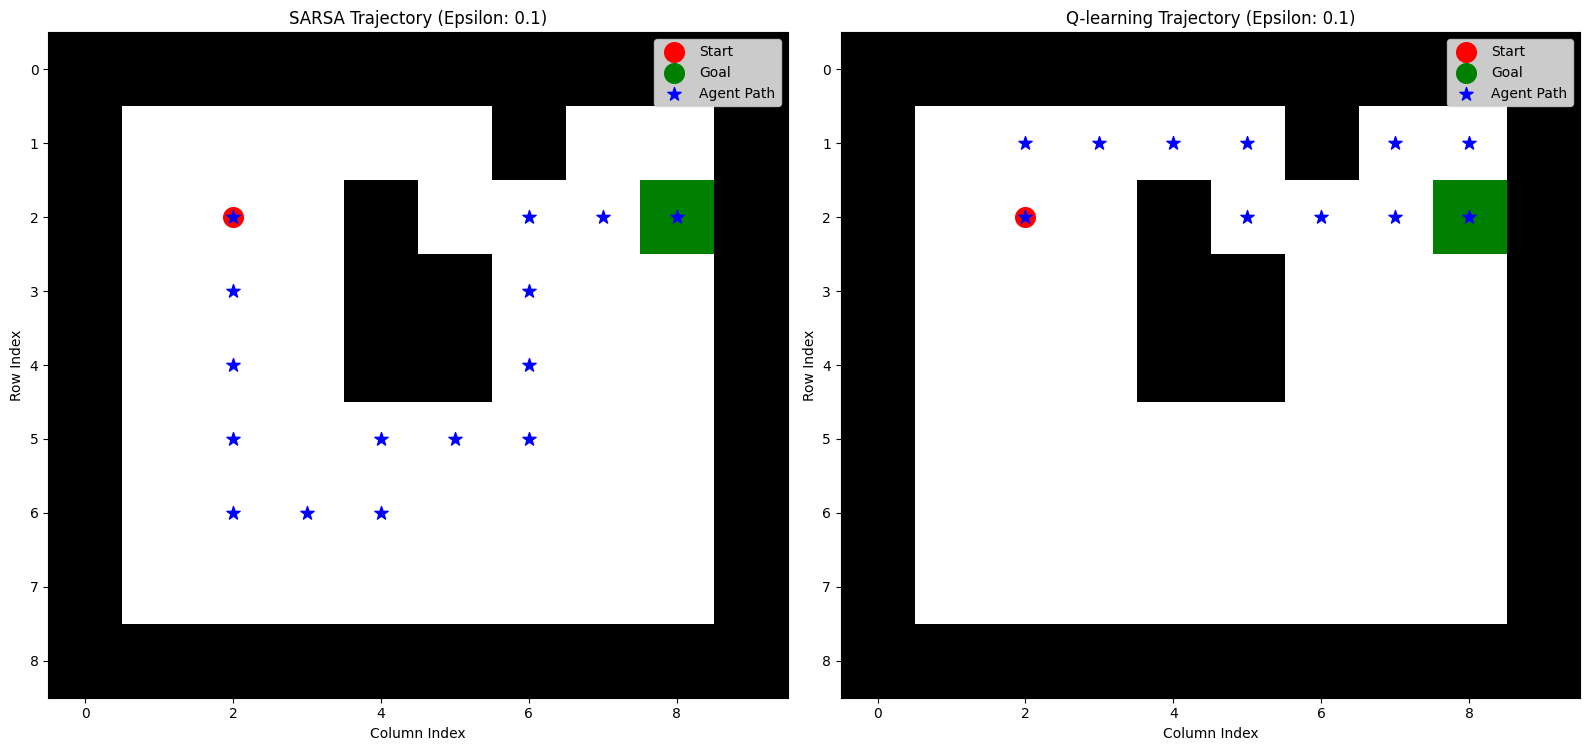

SARSA Learning Time: 0.07 seconds, Steps: 14, average reward 9.565
Q-learning Learning Time: 0.04 seconds, Steps: 10, average reward 5.545


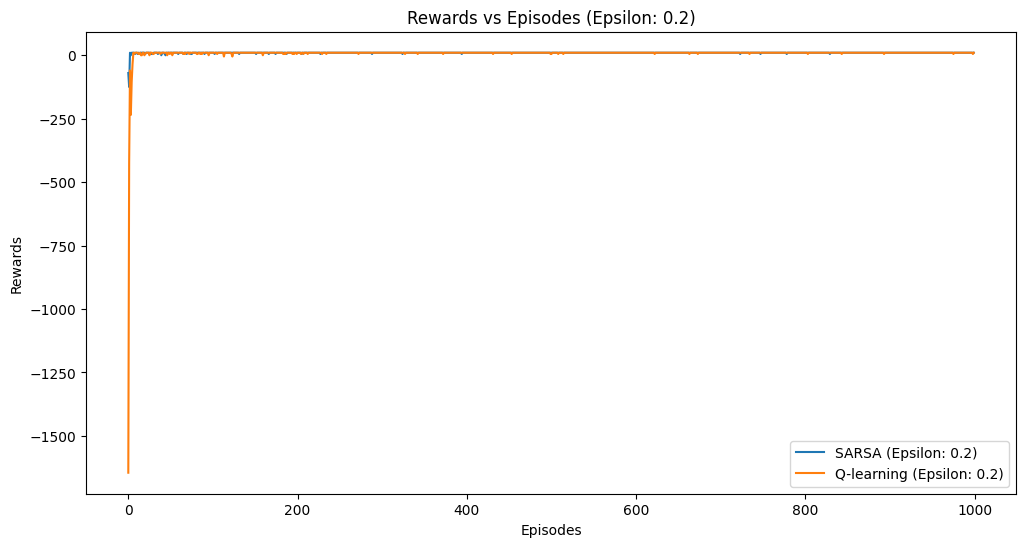

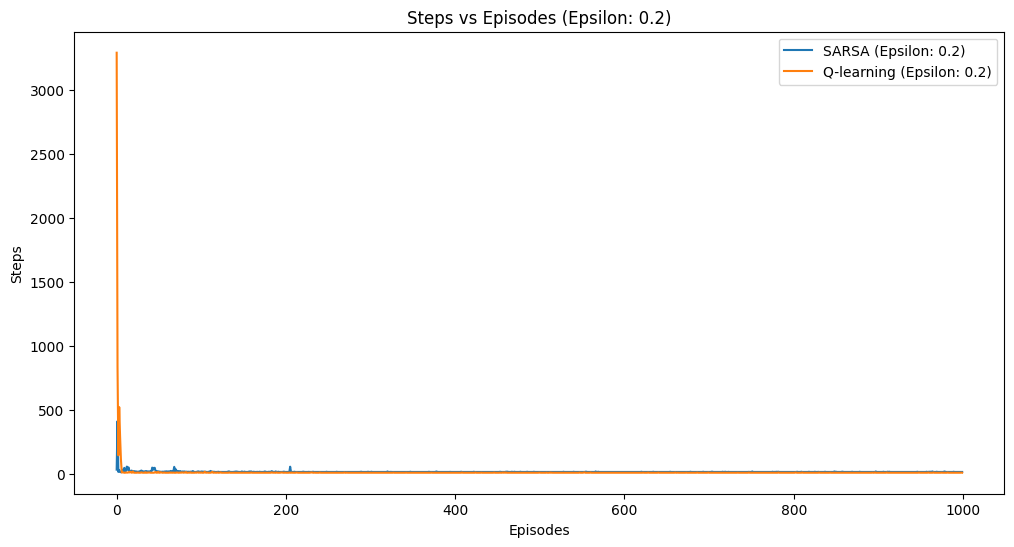

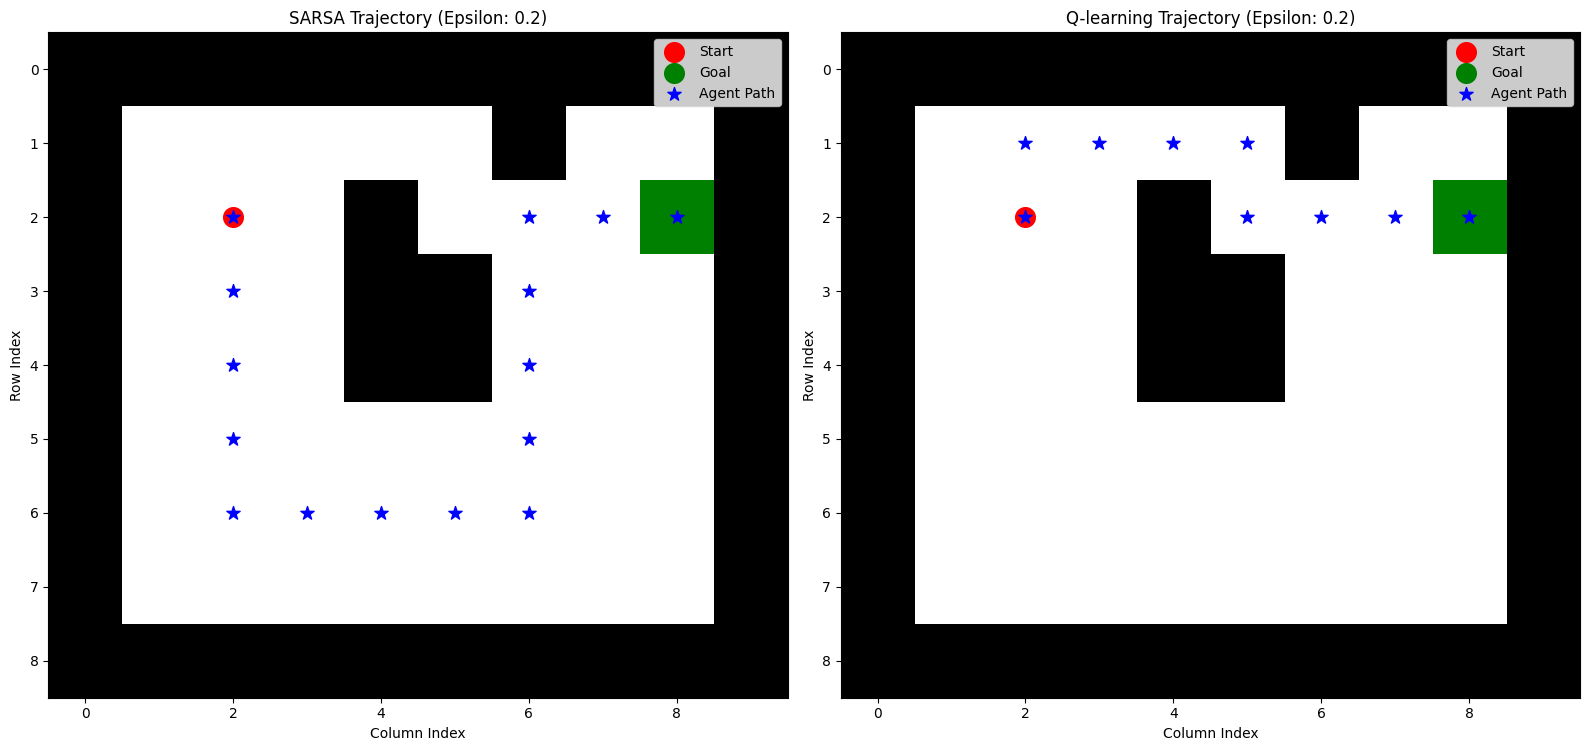

SARSA Learning Time: 0.06 seconds, Steps: 14, average reward 9.605
Q-learning Learning Time: 0.03 seconds, Steps: 8, average reward 7.09


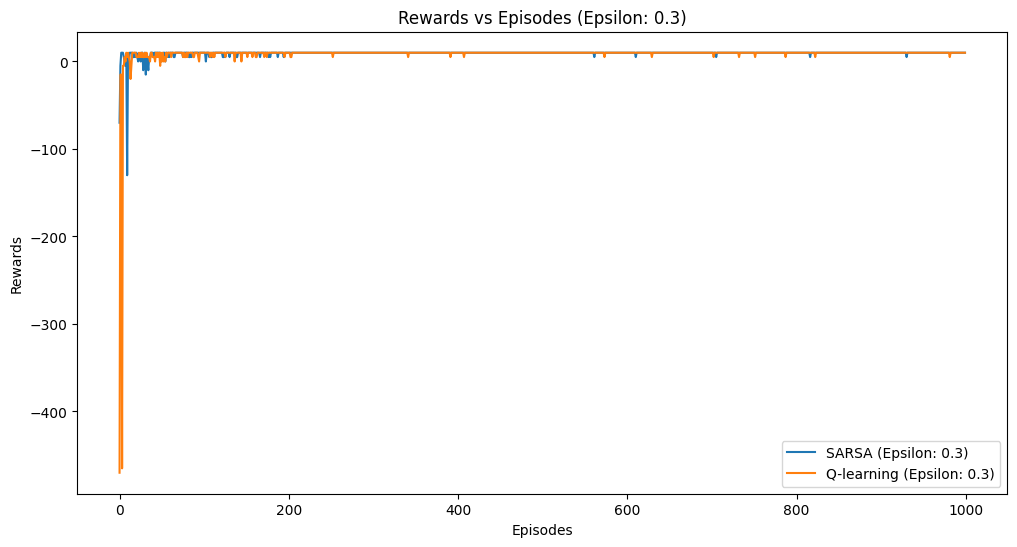

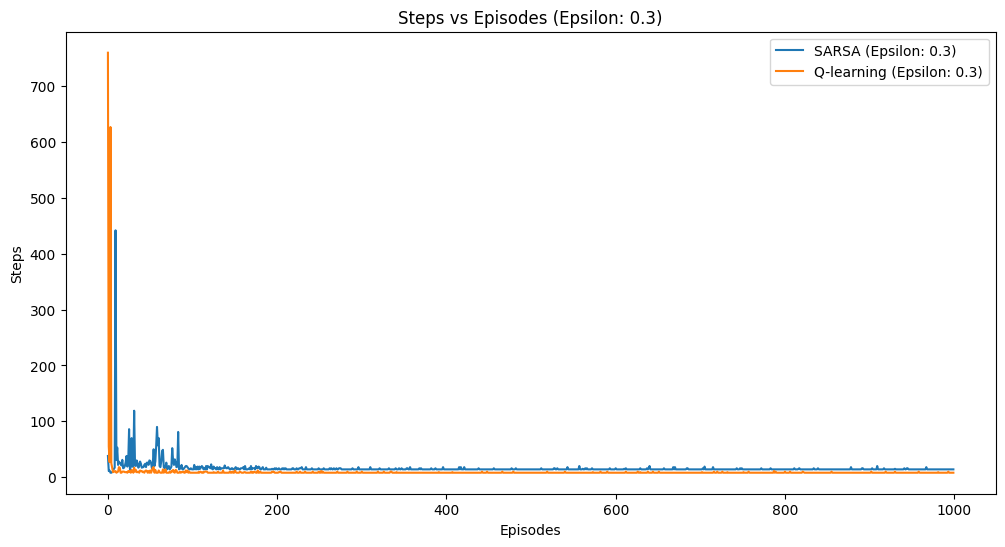

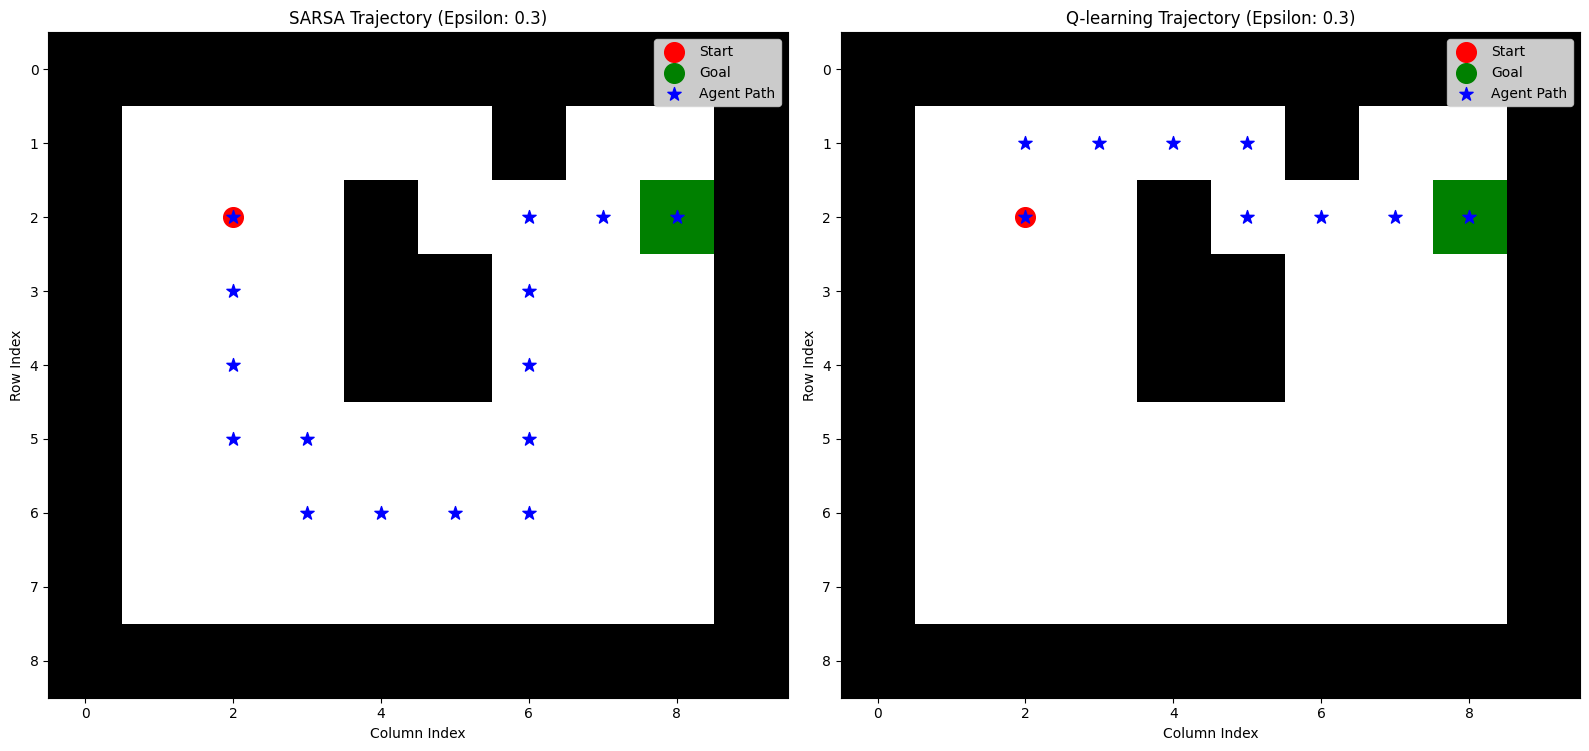

SARSA Learning Time: 0.05 seconds, Steps: 14, average reward 9.385
Q-learning Learning Time: 0.03 seconds, Steps: 8, average reward 8.535


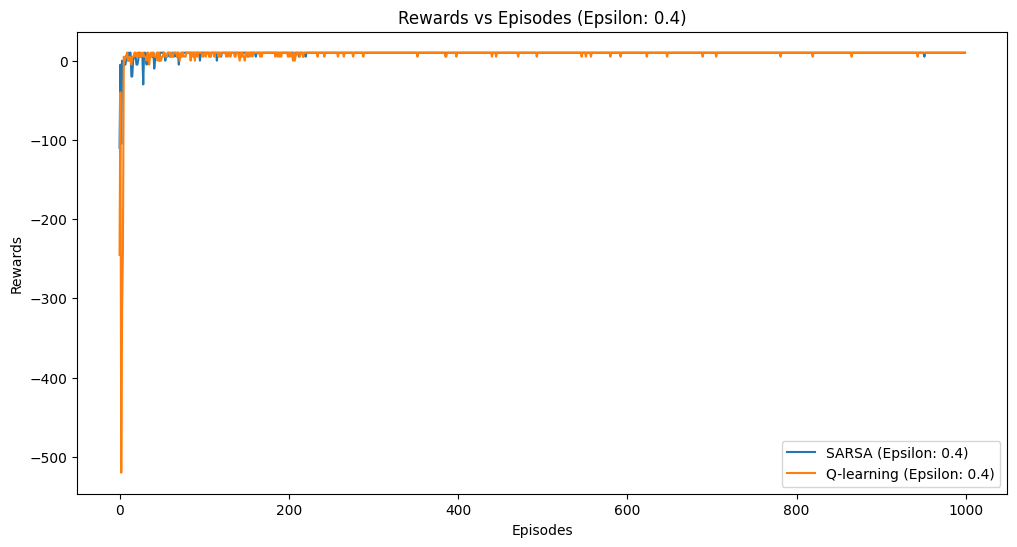

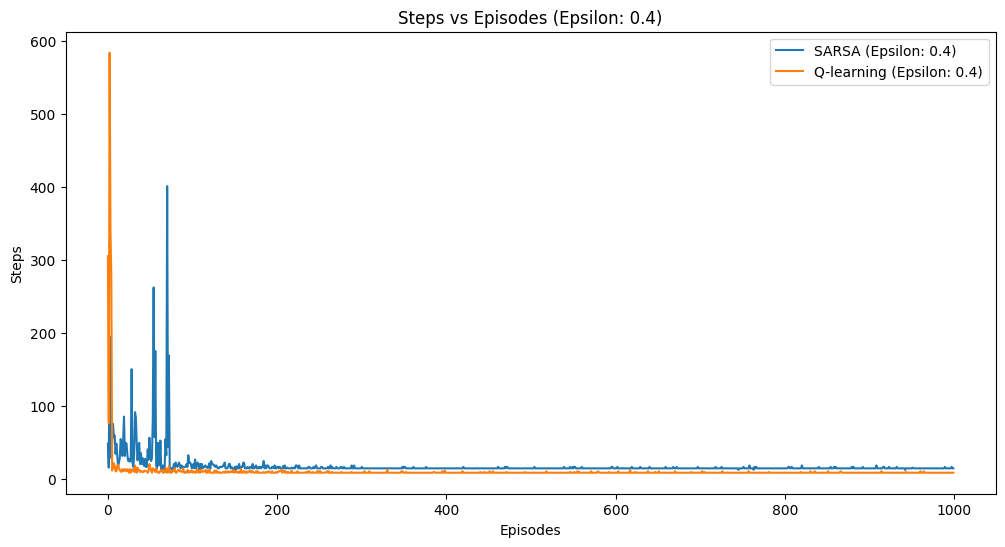

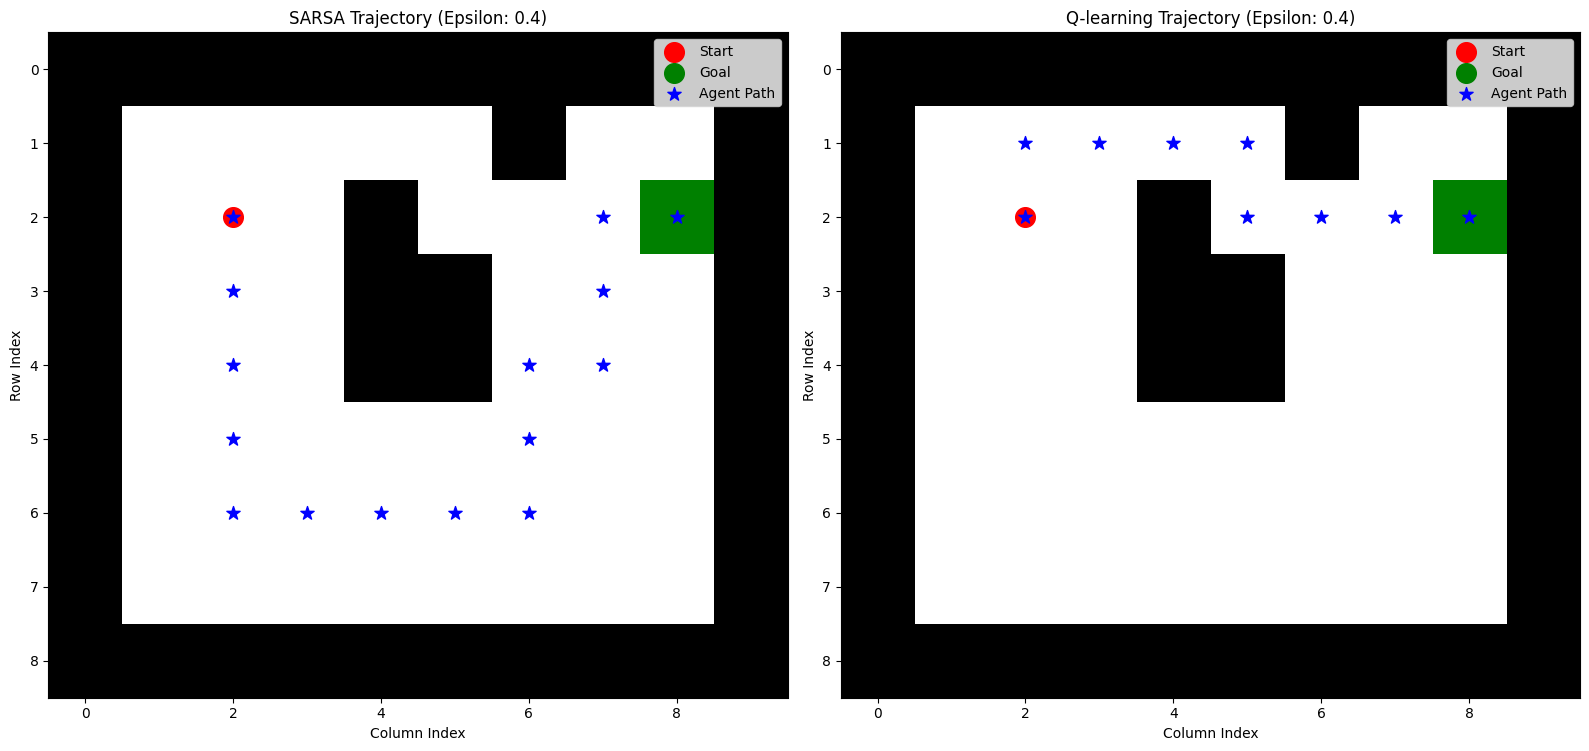

SARSA Learning Time: 0.06 seconds, Steps: 14, average reward 9.26
Q-learning Learning Time: 0.03 seconds, Steps: 8, average reward 7.94


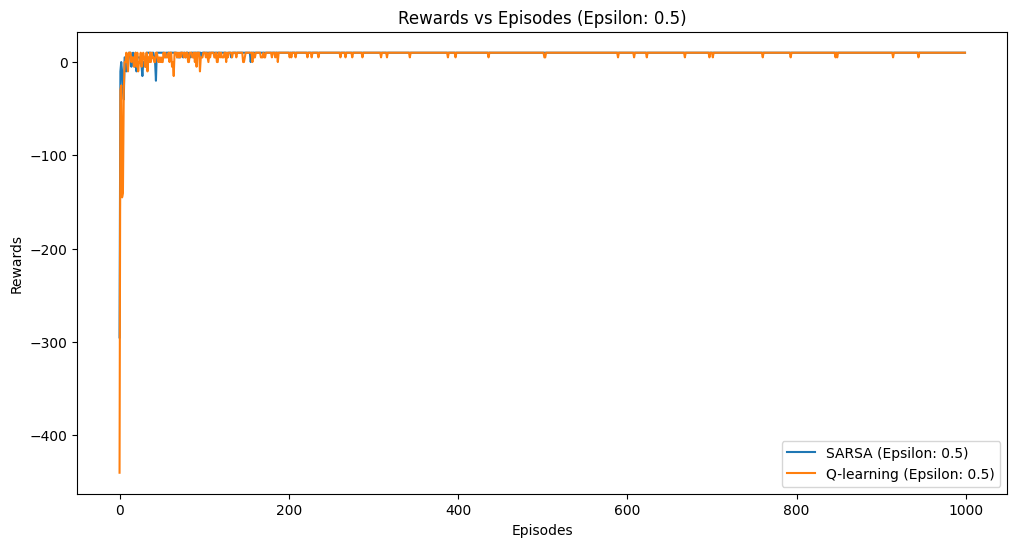

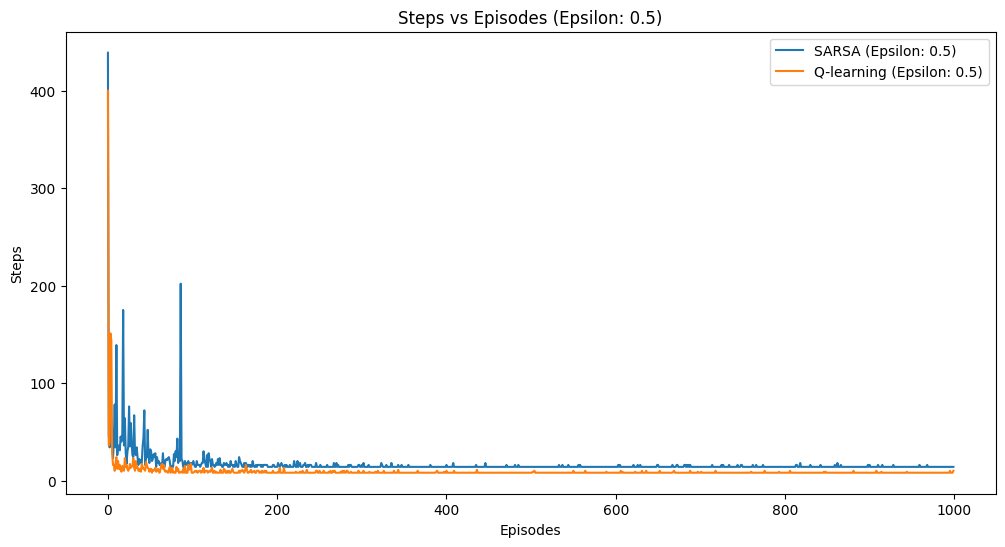

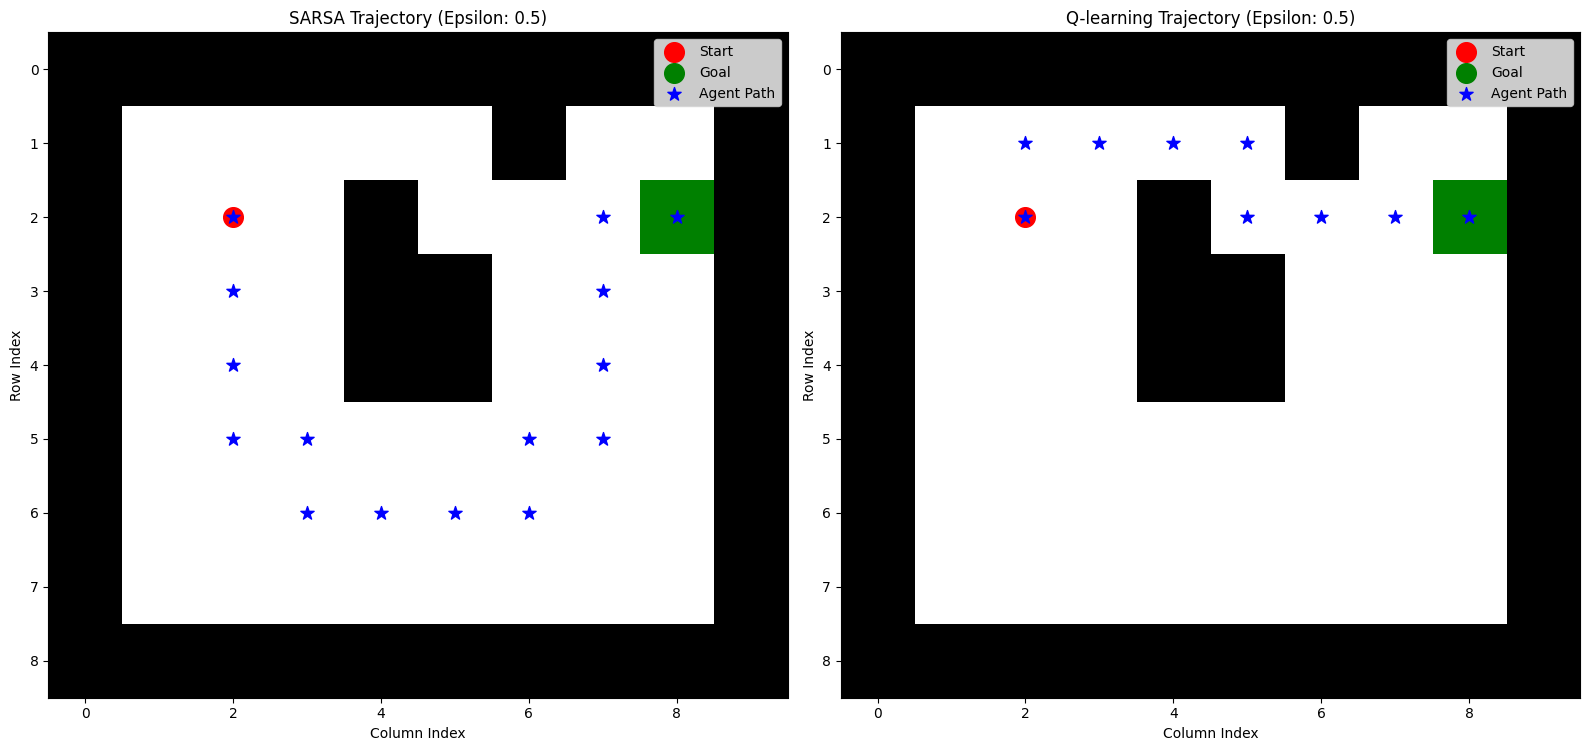

SARSA Learning Time: 0.08 seconds, Steps: 14, average reward 9.205
Q-learning Learning Time: 0.04 seconds, Steps: 8, average reward 8.265


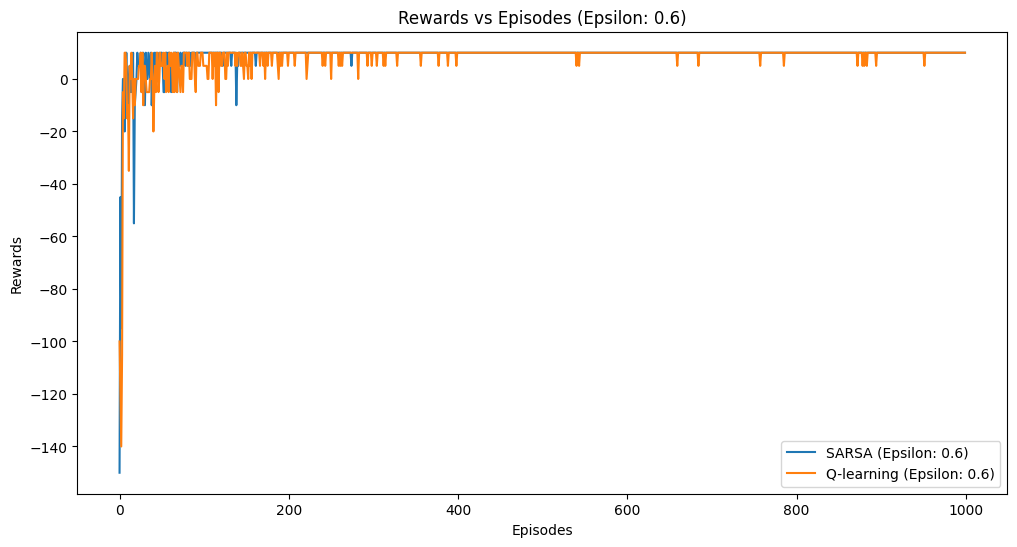

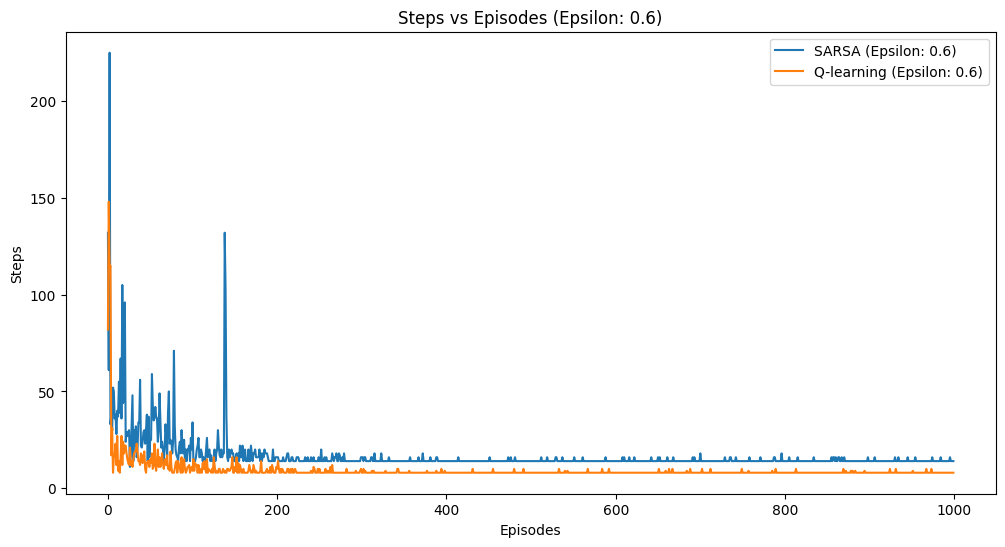

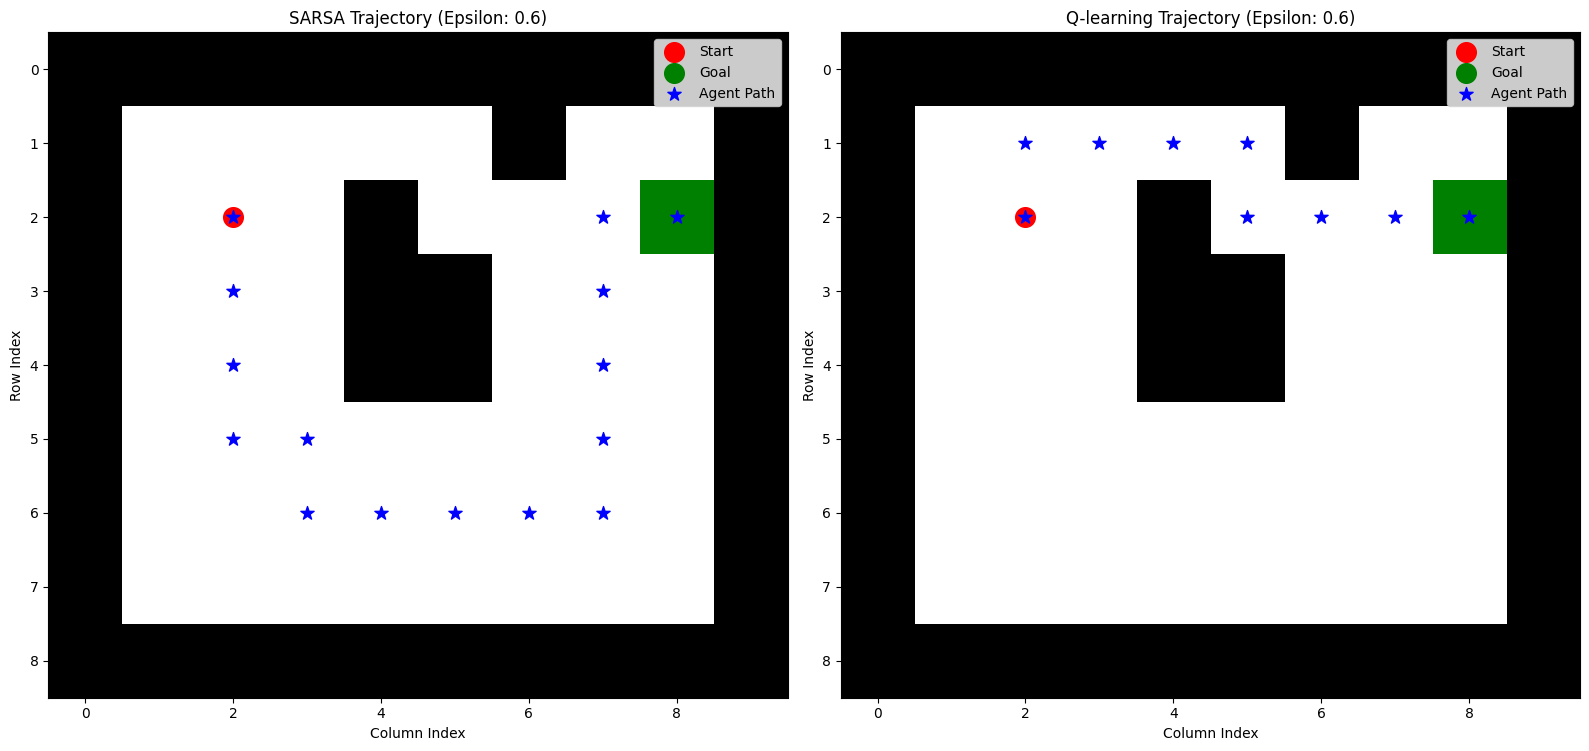

SARSA Learning Time: 0.10 seconds, Steps: 14, average reward 9.05
Q-learning Learning Time: 0.06 seconds, Steps: 8, average reward 8.3


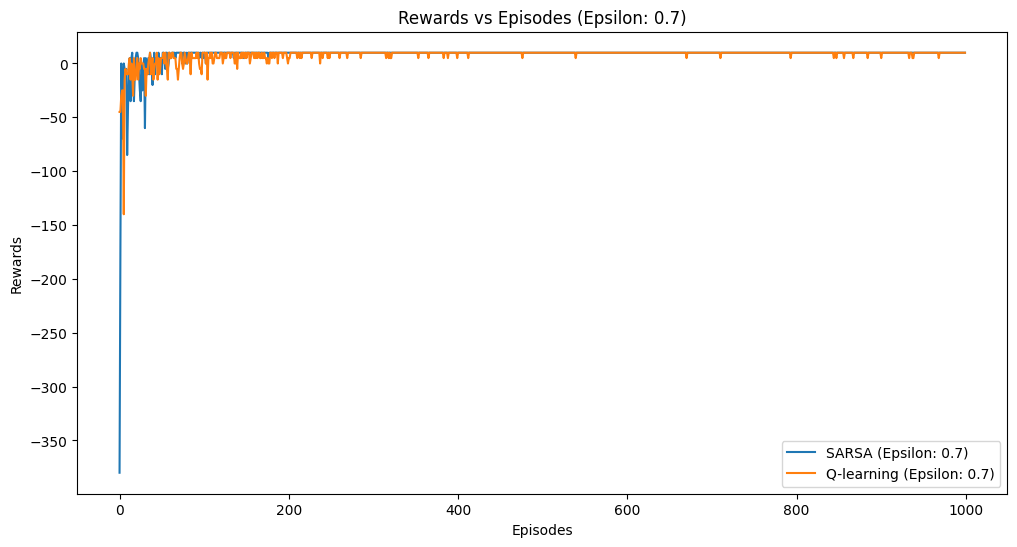

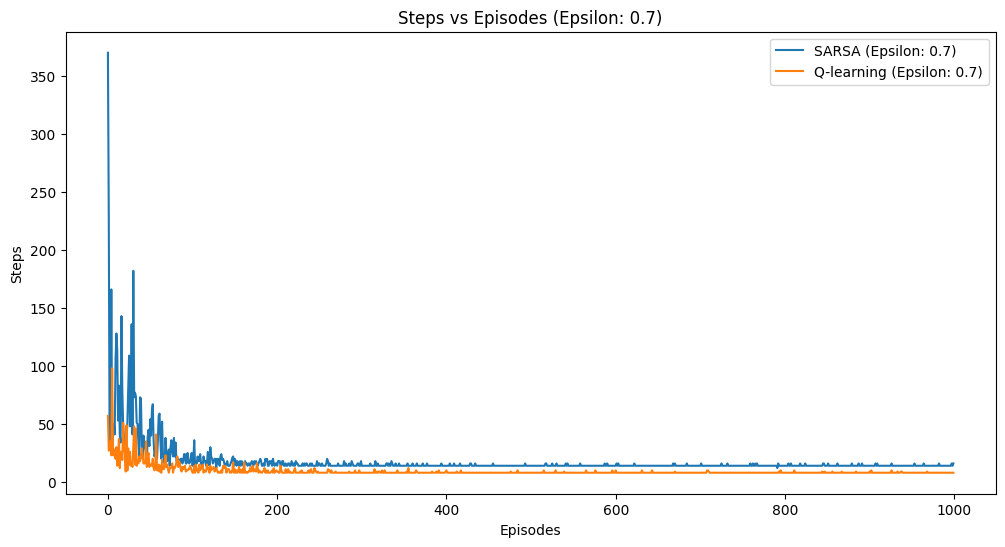

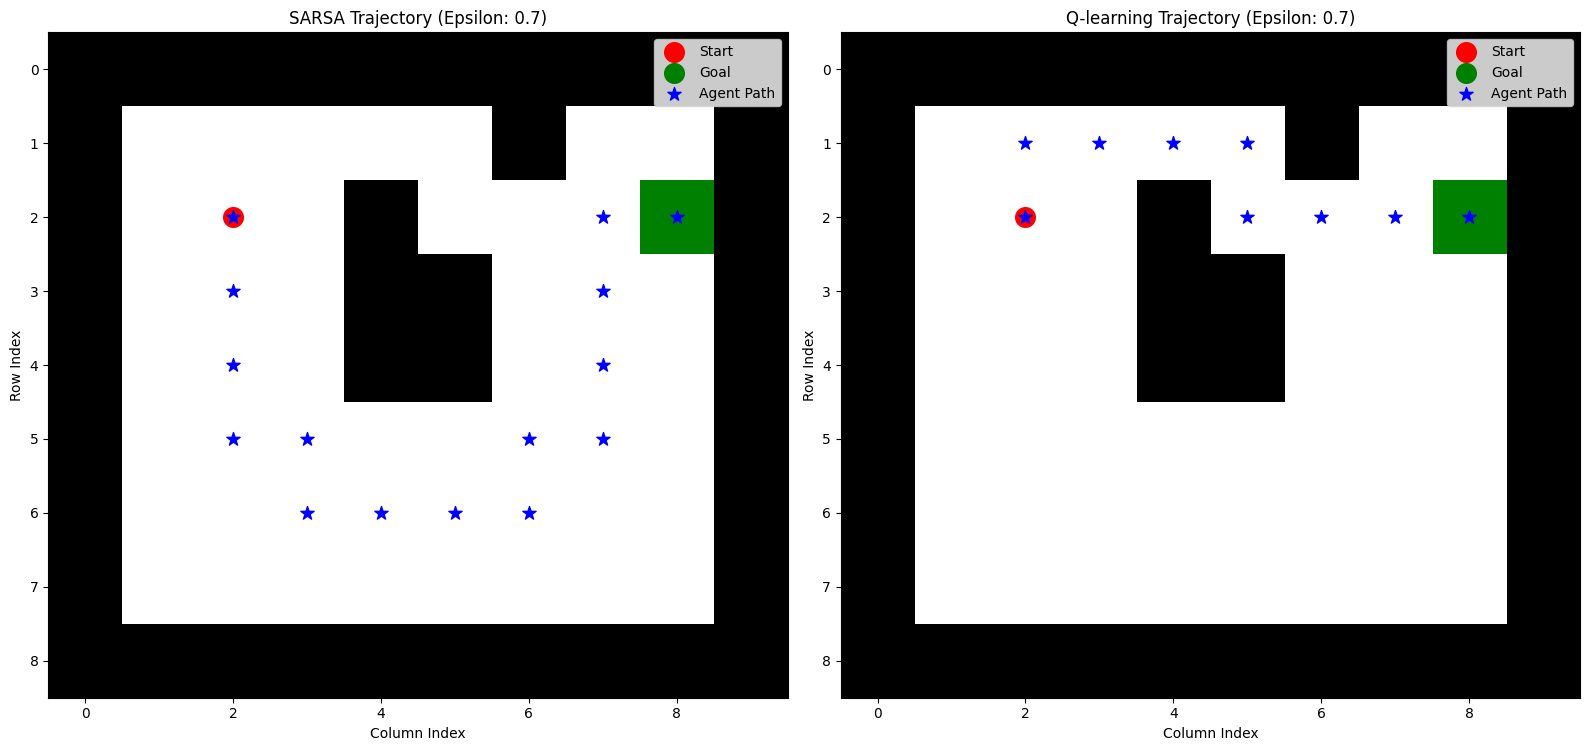

SARSA Learning Time: 0.06 seconds, Steps: 14, average reward 8.355
Q-learning Learning Time: 0.03 seconds, Steps: 8, average reward 8.105


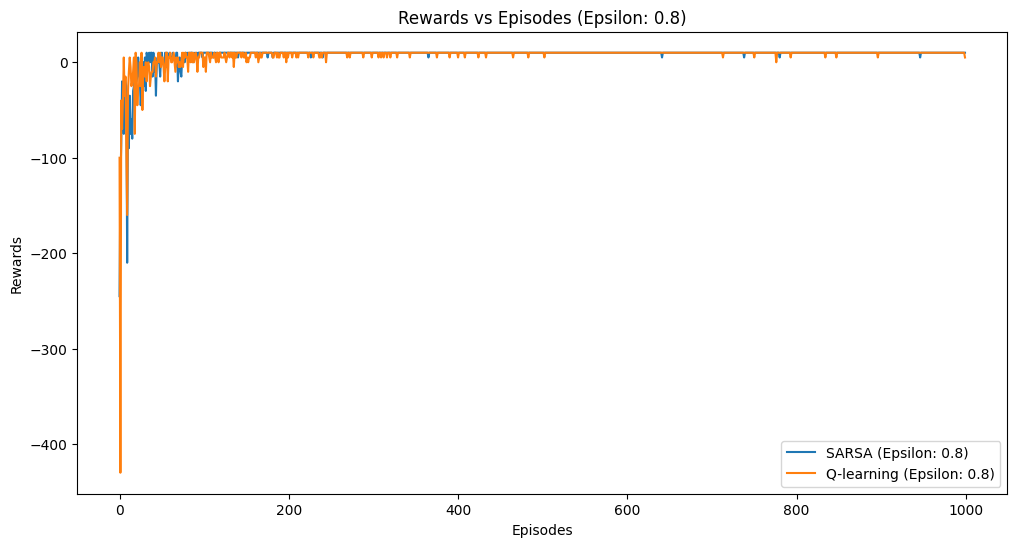

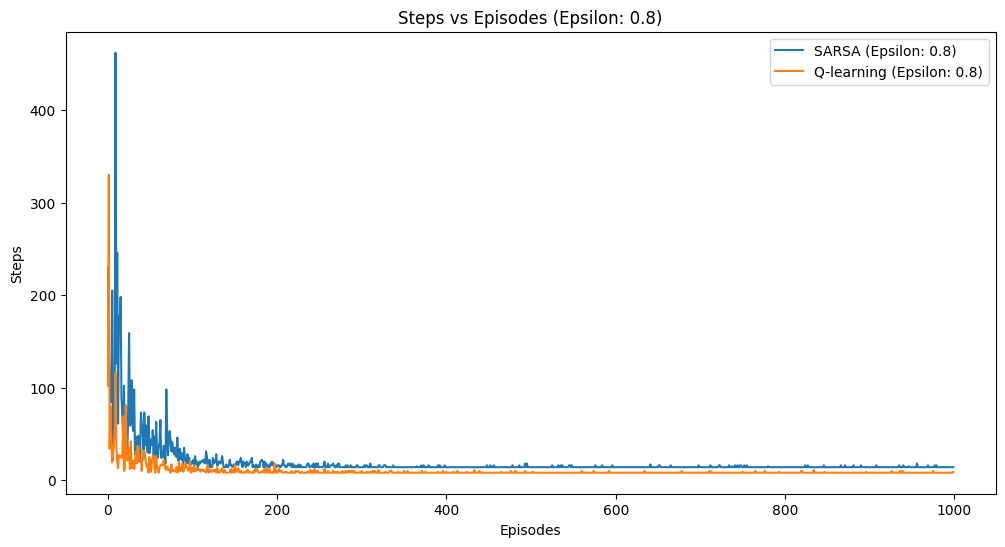

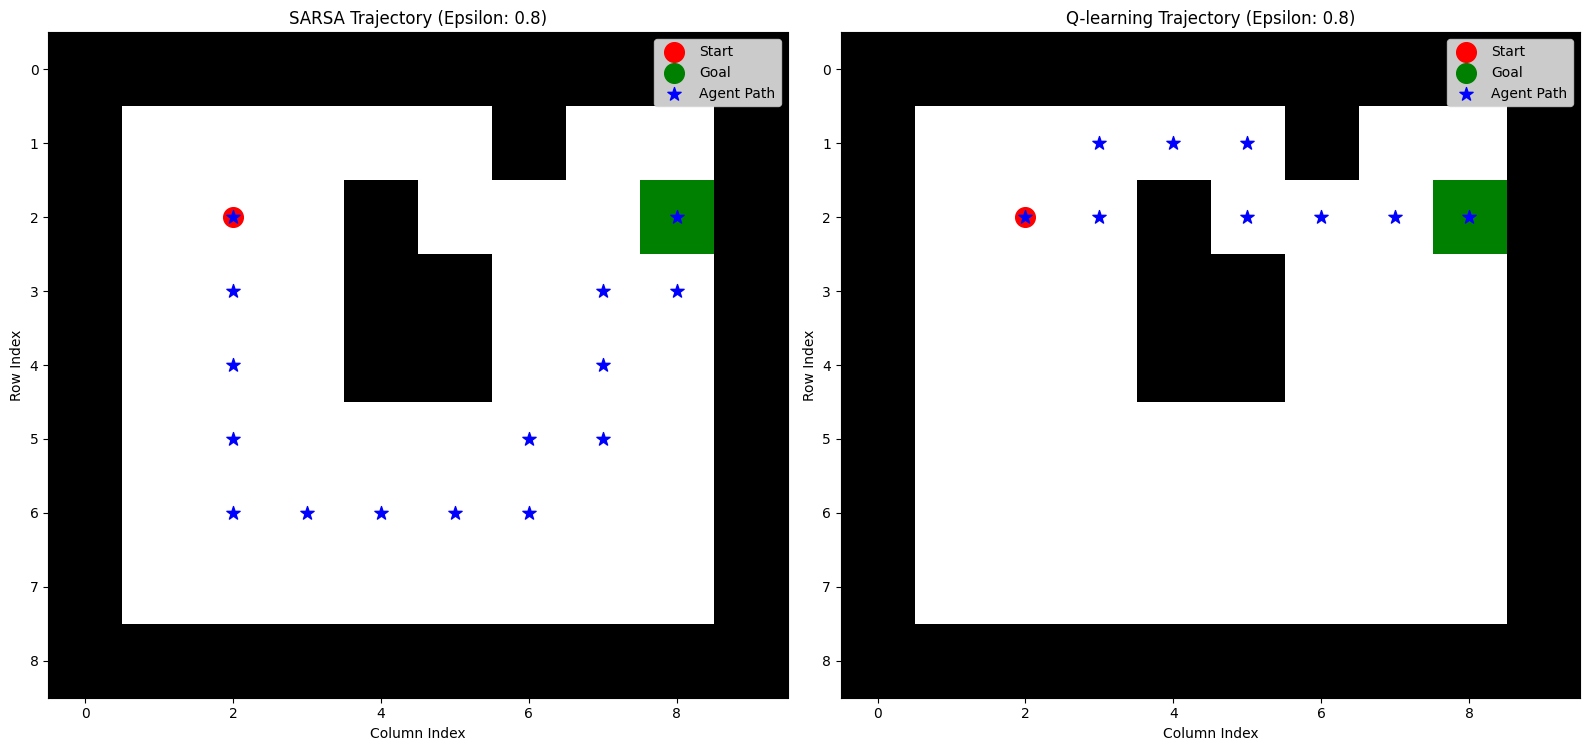

SARSA Learning Time: 0.06 seconds, Steps: 14, average reward 7.635
Q-learning Learning Time: 0.03 seconds, Steps: 8, average reward 7.25


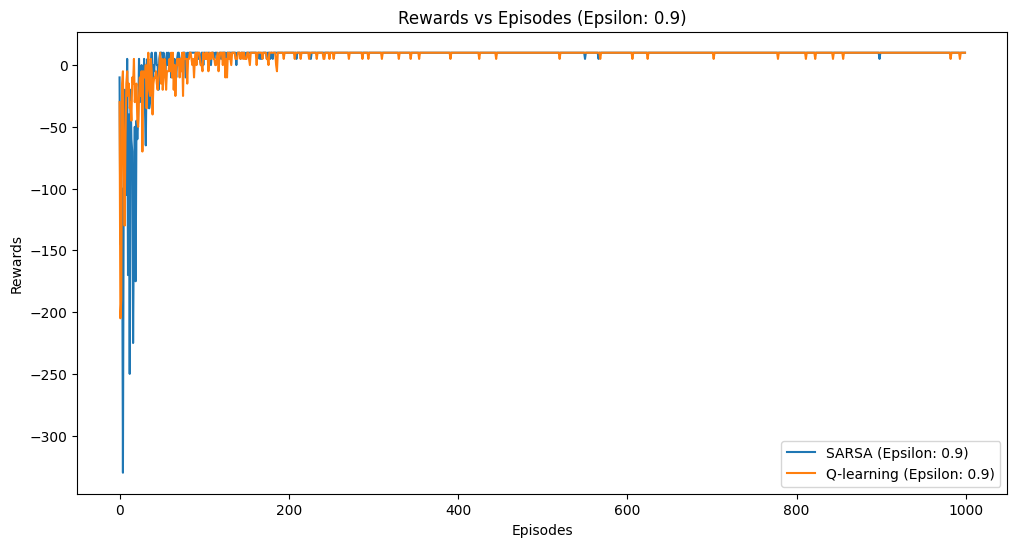

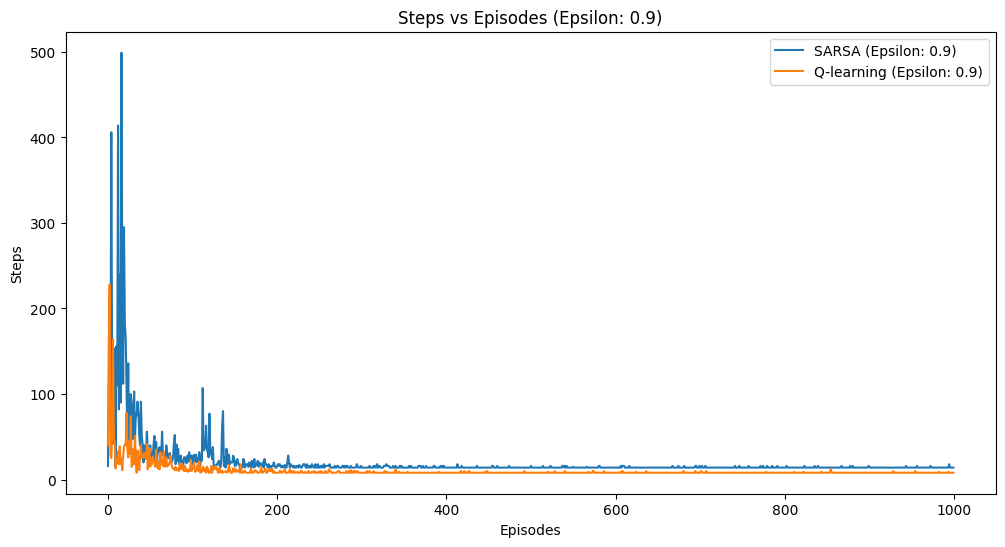

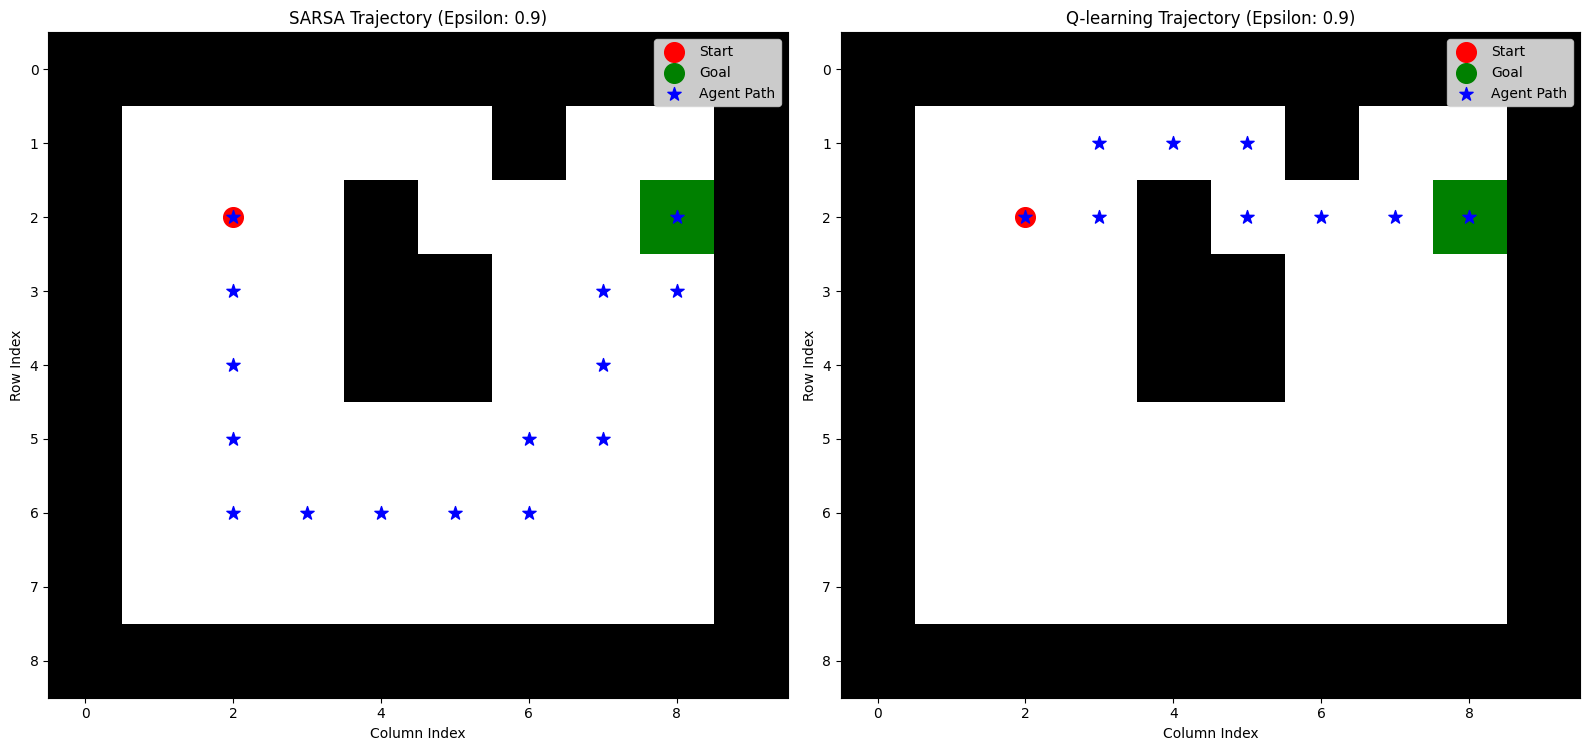

SARSA Learning Time: 0.07 seconds, Steps: 14, average reward 6.605
Q-learning Learning Time: 0.03 seconds, Steps: 8, average reward 7.12


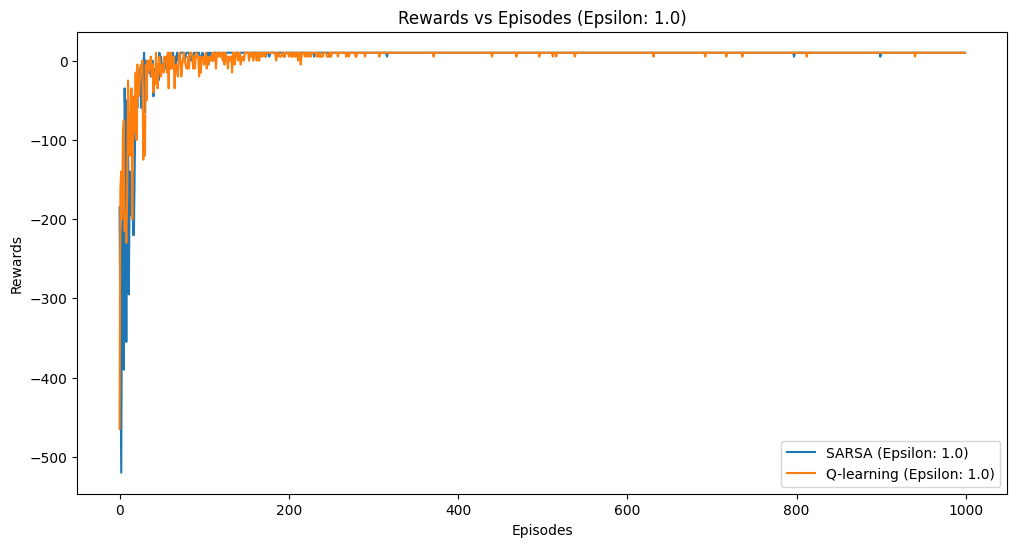

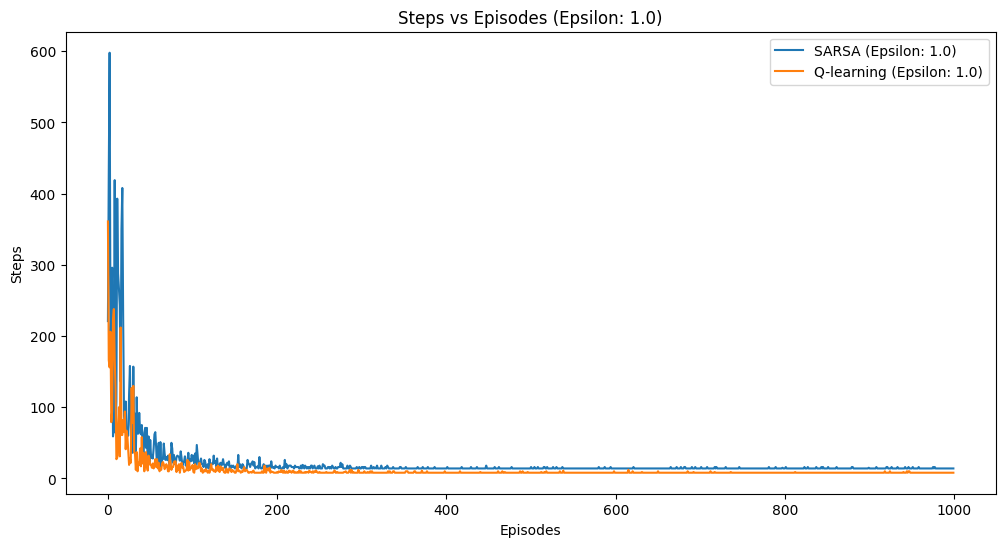

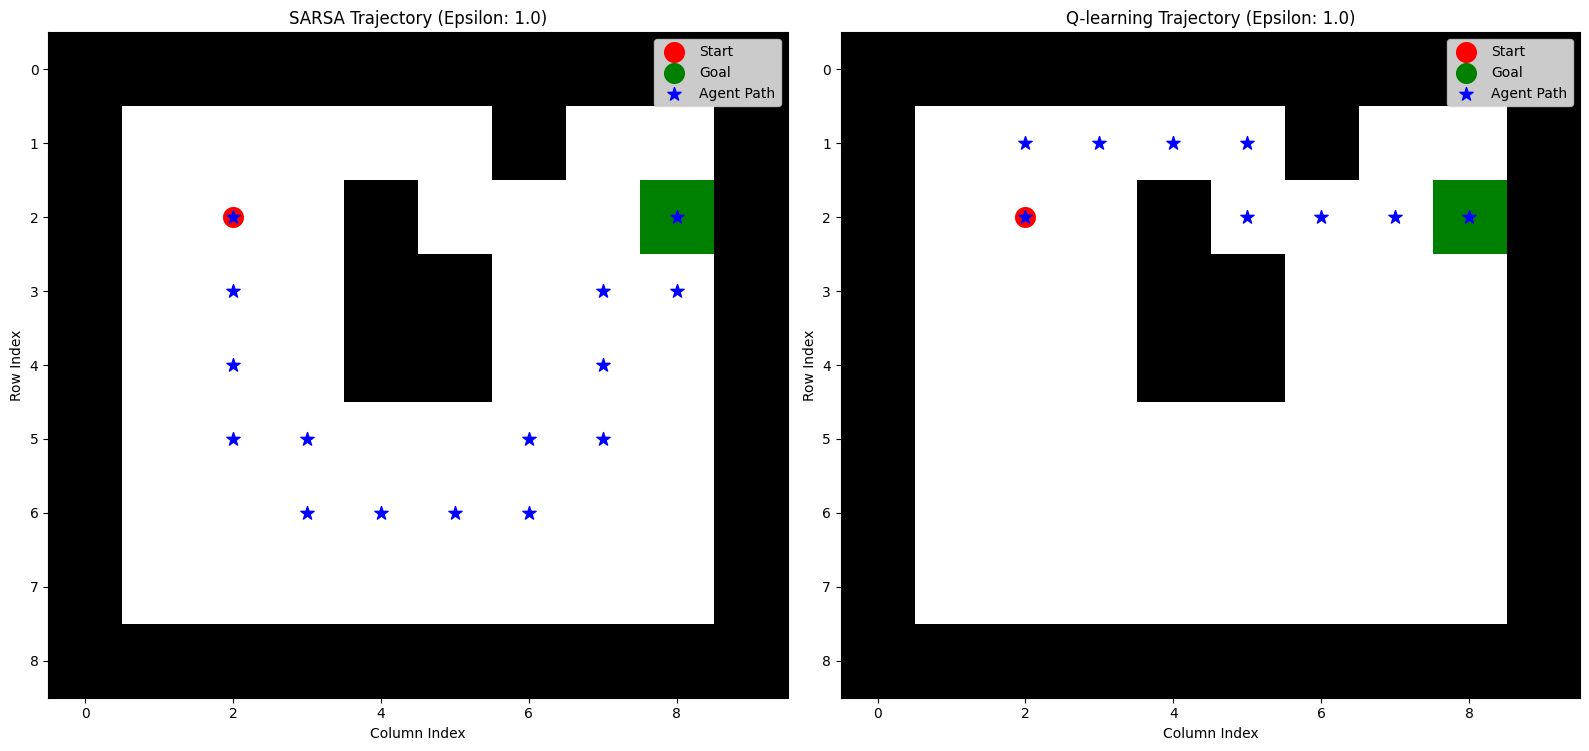

SARSA Learning Time: 0.08 seconds, Steps: 14, average reward 4.48
Q-learning Learning Time: 0.05 seconds, Steps: 8, average reward 4.685


In [ ]:
for i, epsilon in enumerate(epsilon_values):

    plt.figure(figsize=(12, 6))
    plt.plot(all_rewards_sarsa[i], label=f'SARSA (Epsilon: {epsilon})')
    plt.plot(all_rewards_qlearning[i], label=f'Q-learning (Epsilon: {epsilon})')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.title(f'Rewards vs Episodes (Epsilon: {epsilon})')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(all_steps_sarsa[i], label=f'SARSA (Epsilon: {epsilon})')
    plt.plot(all_steps_qlearning[i], label=f'Q-learning (Epsilon: {epsilon})')
    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title(f'Steps vs Episodes (Epsilon: {epsilon})')
    plt.legend()
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    render_trajectory(SARSAgent(Grid_world_Env_Deterministic(), num_episodes=1000, epsilon=epsilon), all_trajectories_sarsa[i], epsilon, 'SARSA', axs[0])
    render_trajectory(QLearningAgent(Grid_world_Env_Deterministic(), num_episodes=1000, epsilon=epsilon), all_trajectories_qlearning[i], epsilon, 'Q-learning', axs[1])
    plt.tight_layout()
    plt.show()

    start_time = time.time()
    sarsa_agent = SARSAgent(Grid_world_Env_Deterministic(), num_episodes=1000, epsilon=epsilon)
    sarsa_trajectory = render_trajectory(sarsa_agent, all_trajectories_sarsa[i], epsilon, 'SARSA', axs[0])
    sarsa_time = time.time() - start_time
    sarsa_steps = len(sarsa_trajectory)-1

    start_time = time.time()
    qlearning_agent = QLearningAgent(Grid_world_Env_Deterministic(), num_episodes=1000, epsilon=epsilon)
    qlearning_trajectory = render_trajectory(qlearning_agent, all_trajectories_qlearning[i], epsilon, 'Q-learning', axs[1])
    qlearning_time = time.time() - start_time
    qlearning_steps = len(qlearning_trajectory)-1


    print(f"SARSA Learning Time: {sarsa_time:.2f} seconds, Steps: {sarsa_steps}, average reward {avg_rewards_sarsa[i]}")
    print(f"Q-learning Learning Time: {qlearning_time:.2f} seconds, Steps: {qlearning_steps}, average reward {avg_rewards_qlearning[i]}")

    print('===========================================================================================================================================================================================')

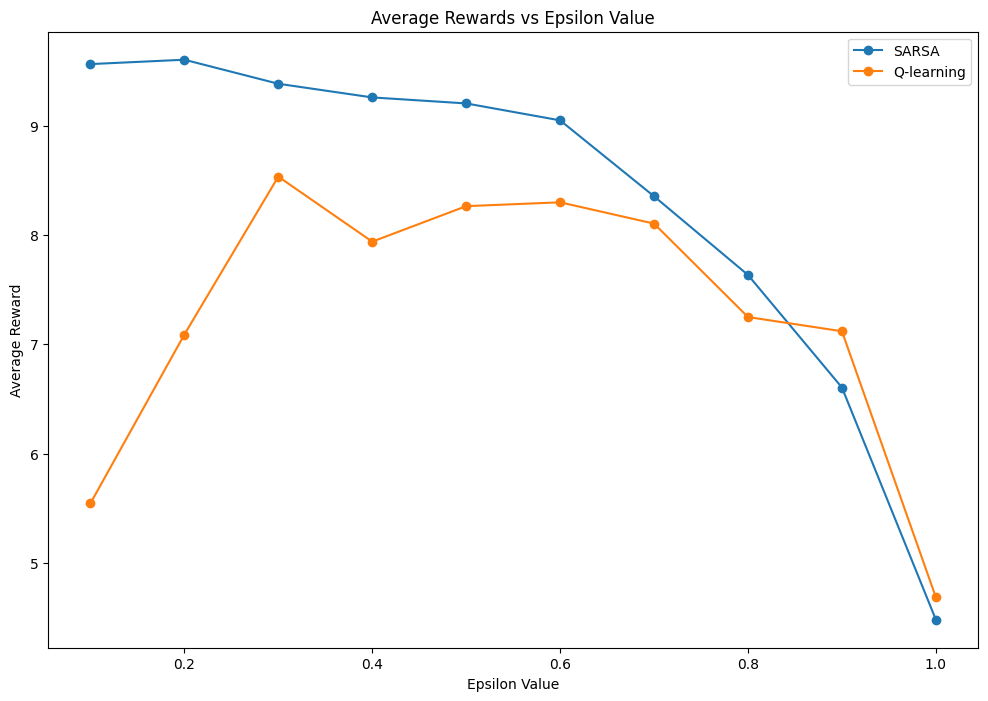

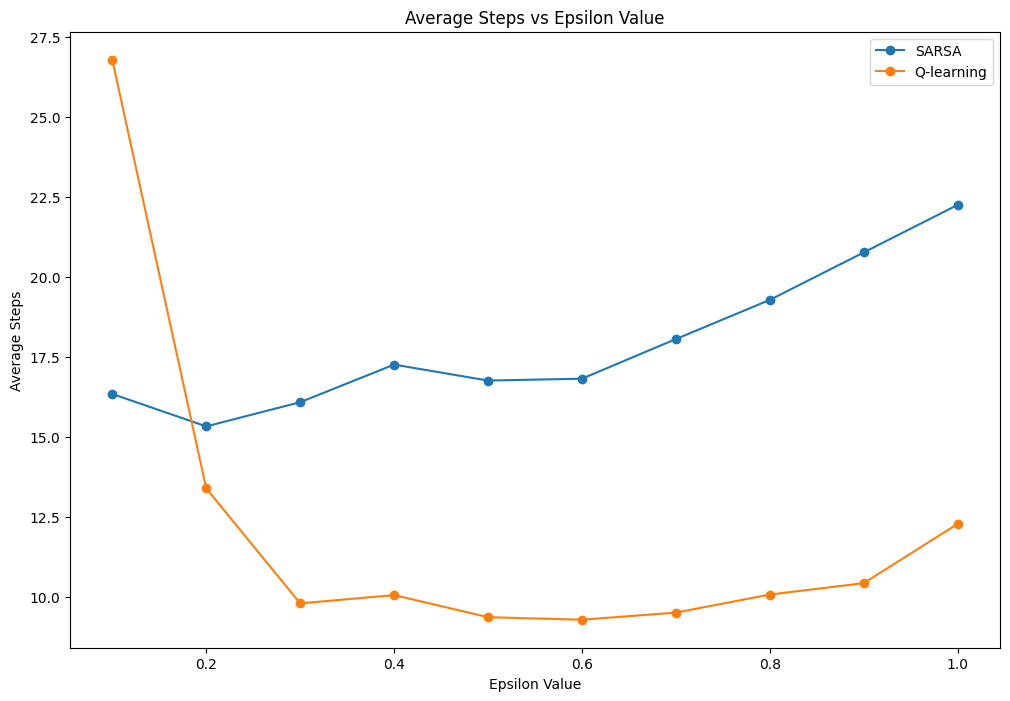

In [ ]:
plot_results(avg_rewards_sarsa, avg_steps_sarsa, avg_rewards_qlearning, avg_steps_qlearning, epsilon_values)

##**Optimal value for epsilon**

In [ ]:
optimal_epsilon_sarsa = epsilon_values[np.argmax(avg_rewards_sarsa)]
optimal_epsilon_qlearning = epsilon_values[np.argmax(avg_rewards_qlearning)]

print(f"Optimal epsilon for SARSA: {optimal_epsilon_sarsa}")
print(f"Optimal epsilon for Q-learning: {optimal_epsilon_qlearning}")


Optimal epsilon for SARSA: 0.2
Optimal epsilon for Q-learning: 0.3


In [ ]:
optimal_epsilon_sarsa = epsilon_values[np.argmin(avg_steps_sarsa)]
optimal_epsilon_qlearning = epsilon_values[np.argmin(avg_steps_qlearning)]

print(f"Optimal epsilon for SARSA: {optimal_epsilon_sarsa}")
print(f"Optimal epsilon for Q-learning: {optimal_epsilon_qlearning}")

Optimal epsilon for SARSA: 0.2
Optimal epsilon for Q-learning: 0.6


#**Using another value for alpha = 0.3**

# **I: Implementing the Sarsa algorithm**

**Description of Sarsa Algorithm (On-policy control for estimating $Q \approx q^*$):**

**Algorithm parameters**: step size $\alpha \in (0, 1]$, small $\epsilon > 0$

- Initialize $Q(s,a)$ arbitrarily except that $Q(terminal,\cdot\;) = 0$

- Loop for each episode:

    - Initialize $S$

    - Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)
  
    - Loop for each step of episode:

        1. Take action $A$, observe $R$, $S^\prime$
        2. Choose $A^\prime$ from $S^\prime$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)
        3. $Q(S, A)  = Q(S, A) + \alpha * (R + \gamma Q(S^\prime, A^\prime) - Q(S, A))$
        4. $S = S^\prime$, $A = A^\prime$ until S is terminal

In [4]:
class SARSAgent:
    def __init__(self, env, num_episodes=1000, alpha=0.3, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.01):
        self.env = env
        self.num_episodes = num_episodes
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = np.zeros((env.grid_size[0], env.grid_size[1], env.action_space.n))
        self.num_steps = 0

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # Exploration
        return np.argmax(self.q_table[state[0], state[1]])  # Exploitation

    def learn(self):
        start_time = time.time()
        rewards, steps_per_episode = [], []
        for episode in range(self.num_episodes):
            state = self.env.reset()
            action = self.choose_action(state)
            done, episode_reward = False, 0
            self.num_steps = 0

            while not done:
                next_state, reward, done, _ = self.env.step(action)
                next_action = self.choose_action(next_state)
                self.q_table[state[0], state[1], action] += self.alpha * (
                        reward + self.gamma * self.q_table[next_state[0], next_state[1], next_action] - self.q_table[state[0], state[1], action])
                state, action = next_state, next_action
                episode_reward += reward
                self.num_steps += 1

            rewards.append(episode_reward)
            steps_per_episode.append(self.num_steps)
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

        learning_time = time.time() - start_time
        return rewards, steps_per_episode, learning_time

    def evaluate_policy(self):
        state = self.env.reset()
        trajectory, done = [state], False
        while not done:
            action = np.argmax(self.q_table[state[0], state[1]])
            state, _, done, _ = self.env.step(action)
            trajectory.append(state)
        return trajectory

    def print_state_values(self):
        print("State Values:")
        for i in range(self.env.grid_size[0]):
            for j in range(self.env.grid_size[1]):
                print(f"{np.max(self.q_table[i, j]):.2f}", end="\t")
            print()

    def print_optimal_policy(self):
        print("Optimal Policy:")
        actions = ['U', 'R', 'L', 'D']
        for i in range(self.env.grid_size[0]):
            for j in range(self.env.grid_size[1]):
                if (i, j) == self.env.goal:
                    print("Goal", end="\t")
                elif (i, j) in self.env.blocked_cells:
                    print("X", end="\t")
                else:
                    print(actions[np.argmax(self.q_table[i, j])], end="\t")
            print()

In [5]:
# Environment setup
env = Grid_world_Env_Deterministic()

# Initialize agent
agent = SARSAgent(env)

# Train the agent
agent.learn()

# Evaluate the learned policy and get trajectory
trajectory = agent.evaluate_policy()

rewards, steps_per_episode, learning_time = agent.learn()
print(f"Learning time: {learning_time:.2f} seconds")

# Print number of steps taken
print(f"Number of steps taken: {len(trajectory) - 1}")

# Print state values and optimal policy in matrix format
print("\nState Values (V(s)):")
agent.print_state_values()
print("\nPolicy (π(s)):")
agent.print_optimal_policy()

# Print trajectory
print("\nTrajectory of agent using optimal policy:")
for step, state in enumerate(trajectory):
    print(f"Step {step}: State {state}")

Learning time: 0.59 seconds
Number of steps taken: 14

State Values (V(s)):
State Values:
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
0.00	-2.98	1.93	-4.03	-4.69	-2.70	0.00	8.07	7.60	0.00	
0.00	1.31	2.46	2.32	0.00	0.01	6.10	10.00	0.00	0.00	
0.00	2.31	2.75	3.08	0.00	0.00	7.96	9.00	10.00	0.00	
0.00	1.29	3.02	3.41	0.00	0.00	7.23	8.10	9.00	0.00	
0.00	0.91	3.29	3.79	4.25	5.76	6.56	7.29	7.56	0.00	
0.00	-1.06	3.68	4.22	4.78	5.31	5.90	6.42	-0.47	0.00	
0.00	-3.48	-1.00	3.63	3.81	3.30	5.14	0.82	-3.13	0.00	
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	

Policy (π(s)):
Optimal Policy:
X	X	X	X	X	X	X	X	X	X	
X	D	D	D	L	D	X	D	D	X	
X	D	D	D	X	R	R	R	Goal	X	
X	R	D	D	X	X	R	R	U	X	
X	R	D	D	X	X	R	U	U	X	
X	R	D	D	D	R	R	U	U	X	
X	R	R	R	R	R	U	U	L	X	
X	R	R	U	U	U	U	U	U	X	
X	X	X	X	X	X	X	X	X	X	

Trajectory of agent using optimal policy:
Step 0: State (2, 2)
Step 1: State (3, 2)
Step 2: State (4, 2)
Step 3: State (4, 3)
Step 4: State (5, 3)
Step 5: State (5, 4)
Step 6: State (6, 4)
Step 7: State (6, 5)
Step 

# **II: Implementing the Q-learning algorithm**

**Description of Q-learning Algorithm (Off-policy control for estimating $Q \approx q^*$):**

**Algorithm parameters**: step size $\alpha \in (0, 1]$, small $\epsilon > 0$

- Initialize $Q(s,a)$ arbitrarily except that $Q(terminal,\cdot\;) = 0$

- Loop for each episode:

    - Initialize $S$
  
    - Loop for each step of episode:

        1. Choose $A$ from $S$ using policy derived from $Q$ (e.g., $\epsilon$-greedy)
        2. Take action $A$, observe $R$, $S^\prime$.
        3. $Q(S, A)  = Q(S, A) + \alpha * (R + \gamma \underset{a}{\rm max}Q(S^\prime, A^\prime) - Q(S, A))$
        4. $S = S^\prime$, $A = A^\prime$ until S is terminal

In [6]:
class QLearningAgent:
    def __init__(self, env, num_episodes=1000, alpha=0.3, gamma=0.9, epsilon=1.0, epsilon_decay=0.99, min_epsilon=0.01):
        self.env = env
        self.num_episodes = num_episodes
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.q_table = np.zeros((env.grid_size[0], env.grid_size[1], env.action_space.n))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # Exploration
        return np.argmax(self.q_table[state[0], state[1]])  # Exploitation

    def learn(self):
        start_time = time.time()
        rewards, steps_per_episode = [], []
        for episode in range(self.num_episodes):
            state = self.env.reset()
            done, episode_reward = False, 0
            self.num_steps = 0

            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                best_next_action = np.argmax(self.q_table[next_state[0], next_state[1]])
                self.q_table[state[0], state[1], action] += self.alpha * (
                        reward + self.gamma * self.q_table[next_state[0], next_state[1], best_next_action] - self.q_table[state[0], state[1], action])
                state = next_state
                episode_reward += reward
                self.num_steps += 1

            rewards.append(episode_reward)
            steps_per_episode.append(self.num_steps)
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

        learning_time = time.time() - start_time
        return rewards, steps_per_episode, learning_time

    def evaluate_policy(self):
        state = self.env.reset()
        trajectory, done = [state], False
        while not done:
            action = np.argmax(self.q_table[state[0], state[1]])
            state, _, done, _ = self.env.step(action)
            trajectory.append(state)
        return trajectory

    def print_state_values(self):
        print("State Values:")
        for i in range(self.env.grid_size[0]):
            for j in range(self.env.grid_size[1]):
                print(f"{np.max(self.q_table[i, j]):.2f}", end="\t")
            print()

    def print_optimal_policy(self):
        print("Optimal Policy:")
        actions = ['U', 'R', 'L', 'D']
        for i in range(self.env.grid_size[0]):
            for j in range(self.env.grid_size[1]):
                if (i, j) == self.env.goal:
                    print("Goal", end="\t")
                elif (i, j) in self.env.blocked_cells:
                    print("X", end="\t")
                else:
                    print(actions[np.argmax(self.q_table[i, j])], end="\t")
            print()

In [7]:
# Environment setup
env = Grid_world_Env_Deterministic()

# Initialize agent
agent = QLearningAgent(env)

# Train the agent
agent.learn()

rewards, steps_per_episode, learning_time = agent.learn()
print(f"Learning time: {learning_time:.2f} seconds")

# Evaluate the learned policy and get trajectory
trajectory = agent.evaluate_policy()

# Print number of steps taken
print(f"Number of steps taken: {len(trajectory) - 1}")

# Print state values and optimal policy in matrix format
print("\nState Values (V(s)):")
agent.print_state_values()
print("\nPolicy (π(s)):")
agent.print_optimal_policy()

# Print trajectory
print("\nTrajectory of agent using optimal policy:")
for step, state in enumerate(trajectory):
    print(f"Step {step}: State {state}")

Learning time: 0.20 seconds
Number of steps taken: 8

State Values (V(s)):
State Values:
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	
0.00	4.78	5.31	5.90	6.56	7.29	0.00	9.00	8.82	0.00	
0.00	4.30	4.78	5.31	0.00	8.10	9.00	10.00	0.00	0.00	
0.00	3.62	4.30	3.63	0.00	0.00	8.10	9.00	9.42	0.00	
0.00	2.14	0.68	1.06	0.00	0.00	7.01	7.57	5.06	0.00	
0.00	0.05	0.03	0.14	0.08	0.56	4.89	1.00	0.63	0.00	
0.00	0.02	0.05	0.08	0.21	0.29	0.49	0.38	0.20	0.00	
0.00	0.01	0.02	0.04	0.04	0.08	0.27	0.16	0.06	0.00	
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	

Policy (π(s)):
Optimal Policy:
X	X	X	X	X	X	X	X	X	X	
X	R	R	R	R	D	X	D	D	X	
X	U	U	U	X	R	R	R	Goal	X	
X	U	U	U	X	X	U	U	U	X	
X	U	L	U	X	X	U	U	U	X	
X	U	L	U	R	R	U	U	U	X	
X	R	R	R	R	R	U	U	L	X	
X	R	U	U	R	R	U	U	U	X	
X	X	X	X	X	X	X	X	X	X	

Trajectory of agent using optimal policy:
Step 0: State (2, 2)
Step 1: State (1, 2)
Step 2: State (1, 3)
Step 3: State (1, 4)
Step 4: State (1, 5)
Step 5: State (2, 5)
Step 6: State (2, 6)
Step 7: State (2, 7)
Step 8: State (2

##**Visualization paths taken by the agent using both algorithms**




In [8]:

def render_trajectory(agent, trajectory):
    grid_copy = np.full(agent.env.grid_size, 0)
    grid_copy[agent.env.goal] = 10
    for cell in agent.env.blocked_cells:
        grid_copy[cell] = -5

    cmap = colors.ListedColormap(['black', 'white', 'green'])
    bounds = [-5.1, -0.9, 0.1, 10.1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(8, 6))
    plt.imshow(grid_copy, cmap=cmap, norm=norm, interpolation='nearest')

    start_x, start_y = agent.env.start
    plt.scatter(start_y, start_x, c='red', s=200, marker='o', label='Start')
    goal_x, goal_y = agent.env.goal
    plt.scatter(goal_y, goal_x, c='green', s=200, marker='o', label='Goal')

    for step, state in enumerate(trajectory):
        plt.scatter(state[1], state[0], c='blue', s=100, marker='*')

    plt.legend()
    plt.title('Agent Trajectory on Grid World Environment')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

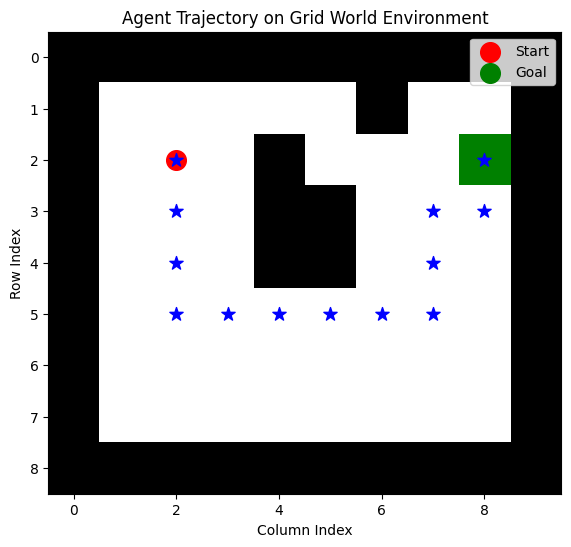

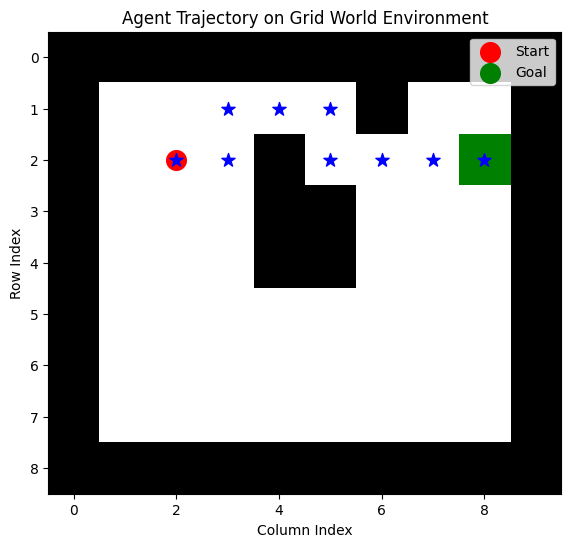

In [9]:
agent_sarsa = SARSAgent(env)
agent_qlearning = QLearningAgent(env)

# Train the agents
agent_sarsa.learn()
agent_qlearning.learn()

# Evaluate policies and render trajectories
trajectory_sarsa = agent_sarsa.evaluate_policy()
render_trajectory(agent_sarsa, trajectory_sarsa)

trajectory_qlearning = agent_qlearning.evaluate_policy()
render_trajectory(agent_qlearning, trajectory_qlearning)

##**Analysis of 2 algorithms through peoposed environment**

In [10]:
def run_experiments(env_class, agent_class, epsilon_values, num_episodes=1000):
    avg_rewards, avg_steps, all_rewards, all_steps, all_trajectories = [], [], [], [], []

    for epsilon in epsilon_values:
        env = env_class()
        agent = agent_class(env, num_episodes=num_episodes, epsilon=epsilon)
        rewards, steps, _ = agent.learn()

        avg_rewards.append(np.mean(rewards))
        avg_steps.append(np.mean(steps))
        all_rewards.append(rewards)
        all_steps.append(steps)
        trajectory = agent.evaluate_policy()
        all_trajectories.append(trajectory)

    return avg_rewards, avg_steps, all_rewards, all_steps, all_trajectories

def plot_results(avg_rewards_sarsa, avg_steps_sarsa, avg_rewards_qlearning, avg_steps_qlearning, epsilon_values):
    plt.figure(figsize=(12, 8))
    plt.plot(epsilon_values, avg_rewards_sarsa, marker='o', label='SARSA')
    plt.plot(epsilon_values, avg_rewards_qlearning, marker='o', label='Q-learning')
    plt.xlabel('Epsilon Value')
    plt.ylabel('Average Reward')
    plt.title('Average Rewards vs Epsilon Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.plot(epsilon_values, avg_steps_sarsa, marker='o', label='SARSA')
    plt.plot(epsilon_values, avg_steps_qlearning, marker='o', label='Q-learning')
    plt.xlabel('Epsilon Value')
    plt.ylabel('Average Steps')
    plt.title('Average Steps vs Epsilon Value')
    plt.legend()
    plt.show()

def render_trajectory(agent, trajectory, epsilon, algorithm, ax):
    grid_copy = np.full(agent.env.grid_size, 0)
    grid_copy[agent.env.goal] = 10
    for cell in agent.env.blocked_cells:
        grid_copy[cell] = -5

    cmap = colors.ListedColormap(['black', 'white', 'green'])
    bounds = [-5.1, -0.9, 0.1, 10.1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    ax.imshow(grid_copy, cmap=cmap, norm=norm, interpolation='nearest')

    start_x, start_y = agent.env.start
    ax.scatter(start_y, start_x, c='red', s=200, marker='o', label='Start')
    goal_x, goal_y = agent.env.goal
    ax.scatter(goal_y, goal_x, c='green', s=200, marker='o', label='Goal')

    for step, state in enumerate(trajectory):
        if step == 0:
            ax.scatter(state[1], state[0], c='blue', s=100, marker='*', label='Agent Path')
        else:
            ax.scatter(state[1], state[0], c='blue', s=100, marker='*')

    ax.legend()
    ax.set_title(f'{algorithm} Trajectory (Epsilon: {epsilon})')
    ax.set_xlabel('Column Index')
    ax.set_ylabel('Row Index')

    return trajectory

In [11]:
epsilon_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

avg_rewards_sarsa, avg_steps_sarsa, all_rewards_sarsa, all_steps_sarsa, all_trajectories_sarsa = run_experiments(Grid_world_Env_Deterministic, SARSAgent, epsilon_values, num_episodes=1000)
avg_rewards_qlearning, avg_steps_qlearning, all_rewards_qlearning, all_steps_qlearning, all_trajectories_qlearning = run_experiments(Grid_world_Env_Deterministic, QLearningAgent, epsilon_values, num_episodes=1000)


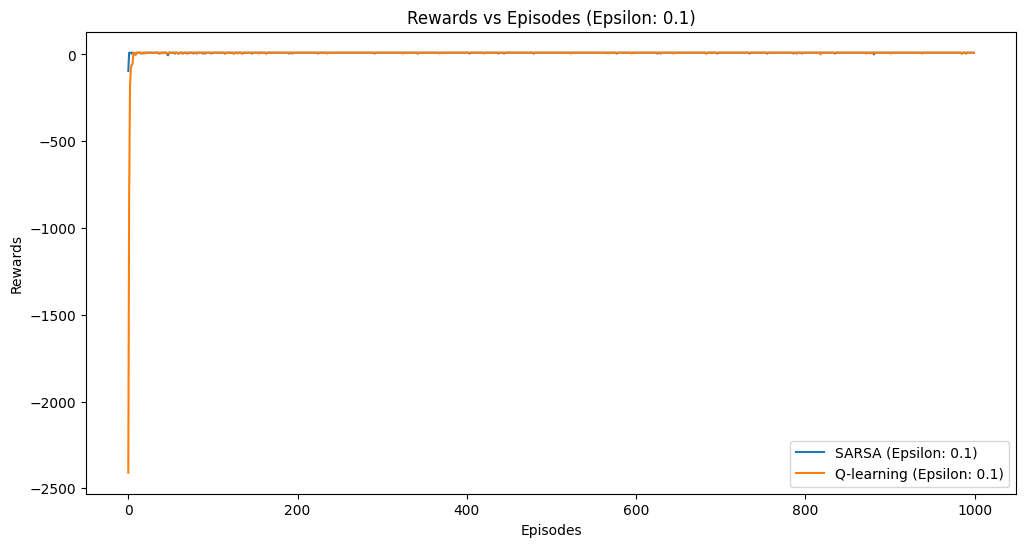

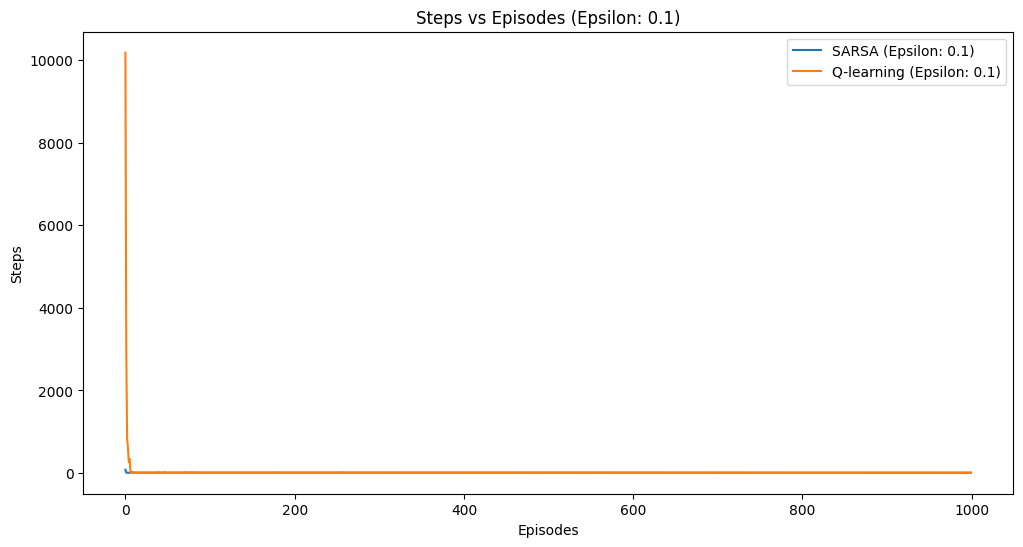

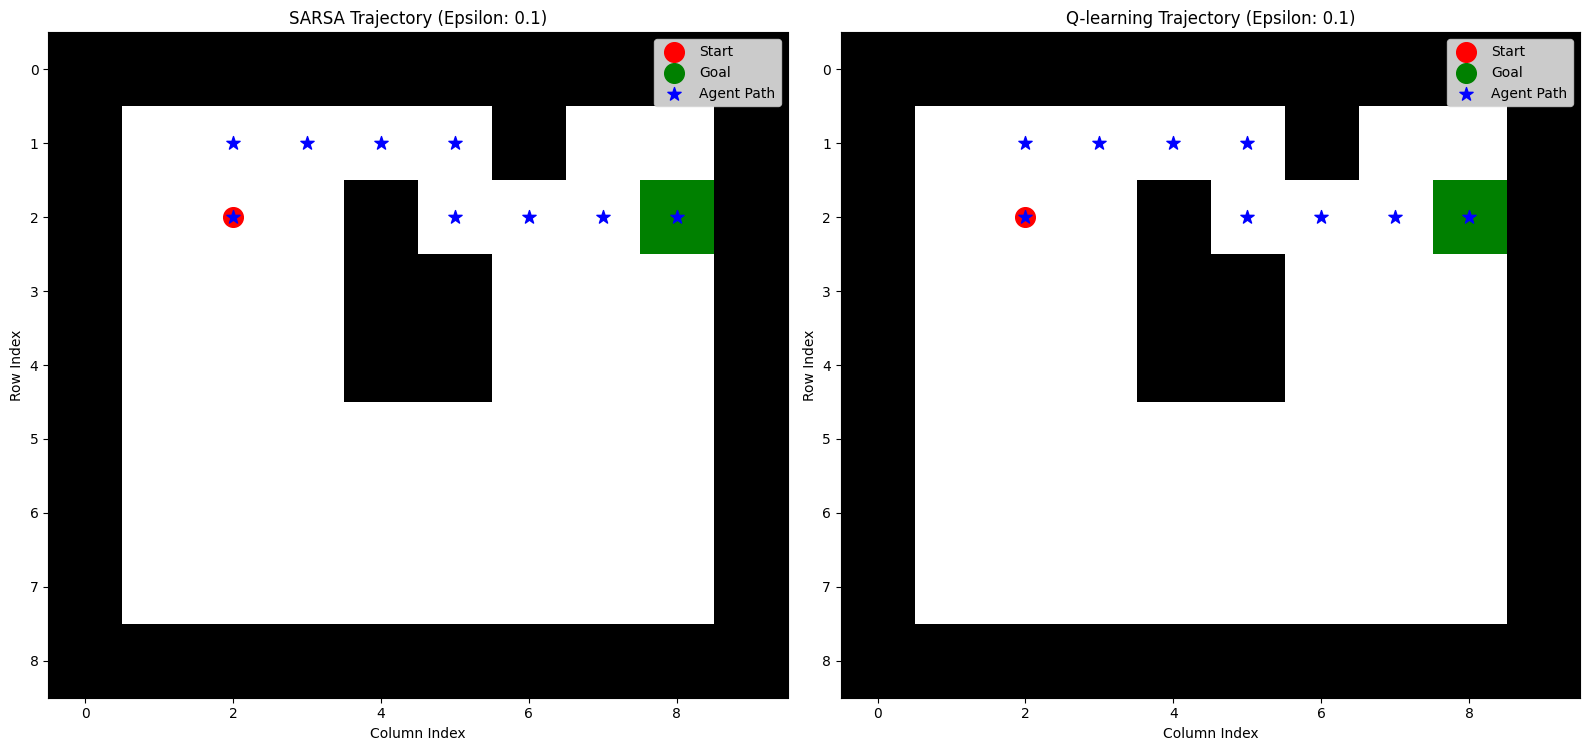

SARSA Learning Time: 0.05 seconds, Steps: 8, average reward 9.64
Q-learning Learning Time: 0.04 seconds, Steps: 8, average reward 6.135


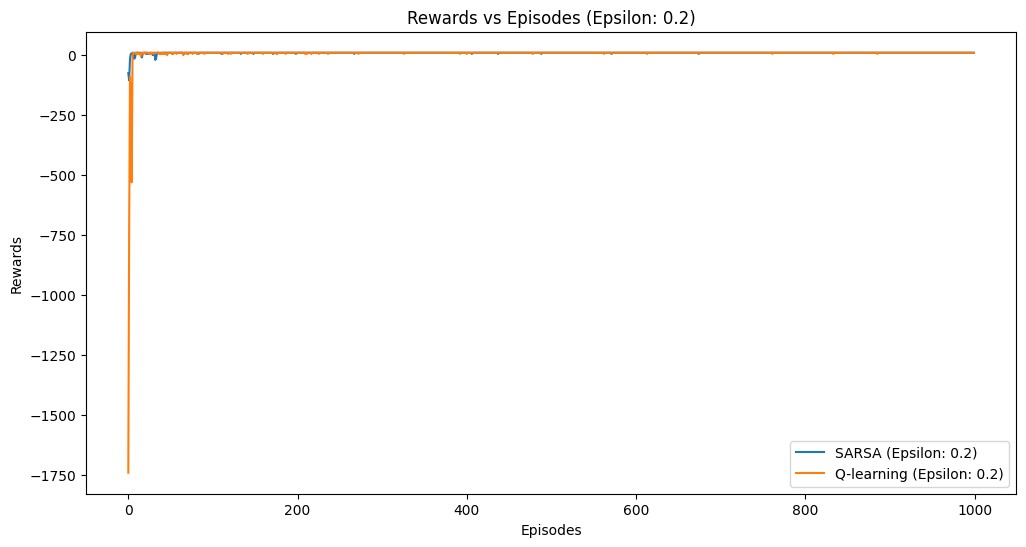

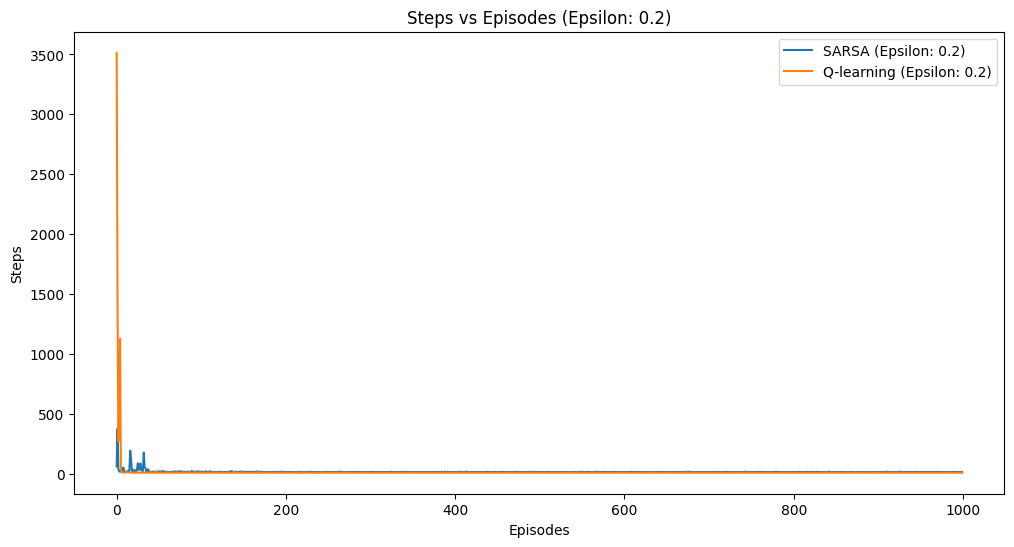

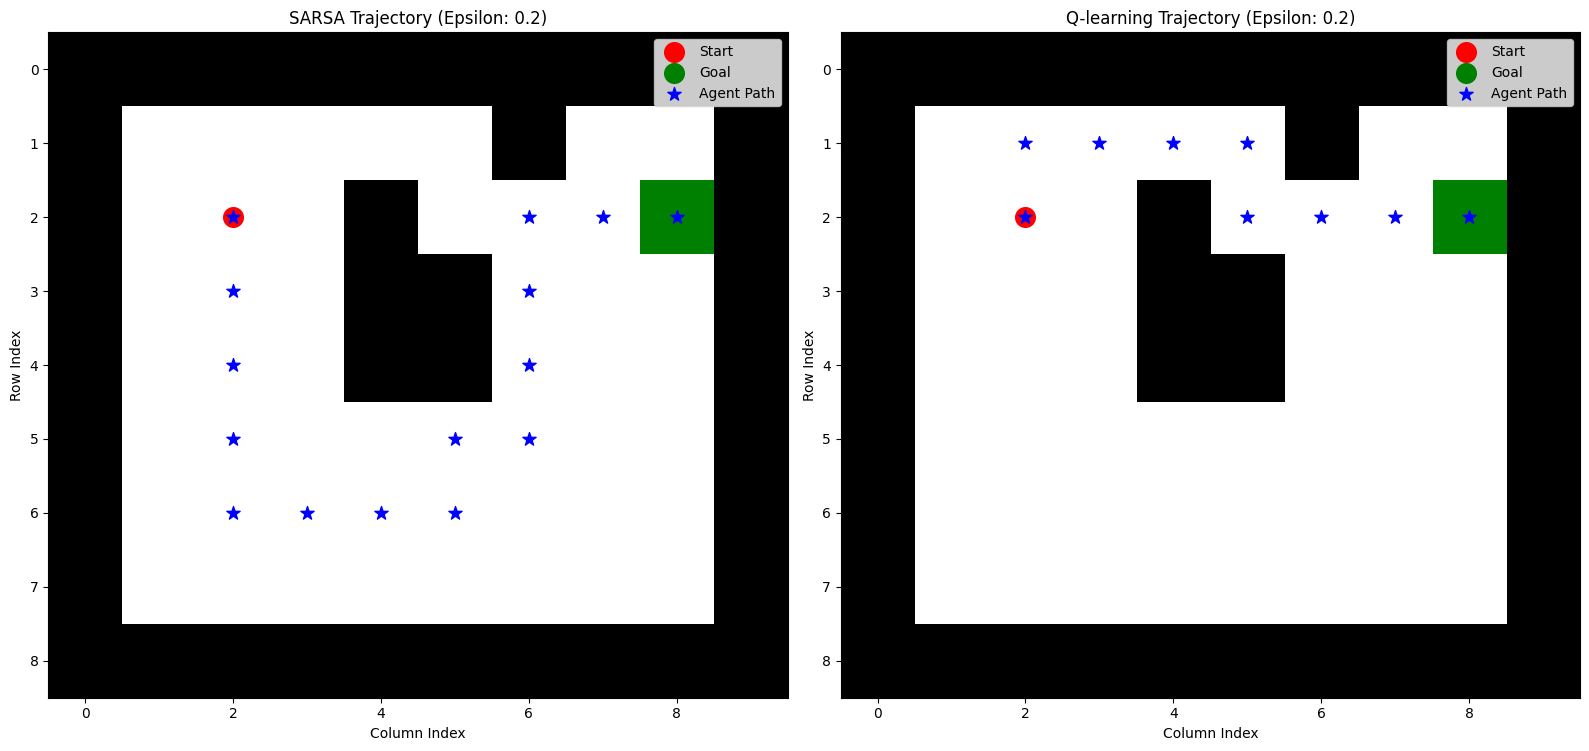

SARSA Learning Time: 0.06 seconds, Steps: 14, average reward 9.51
Q-learning Learning Time: 0.03 seconds, Steps: 8, average reward 6.395


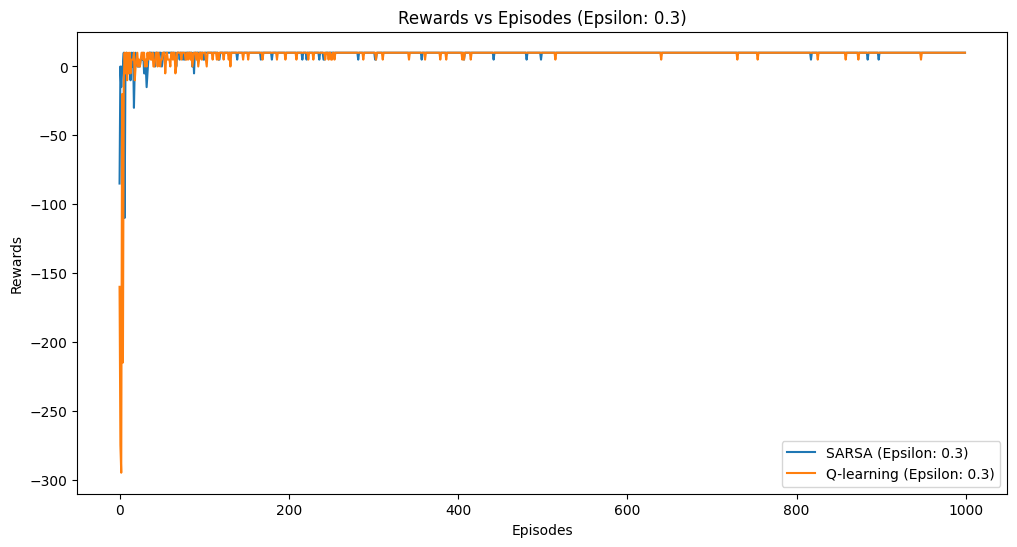

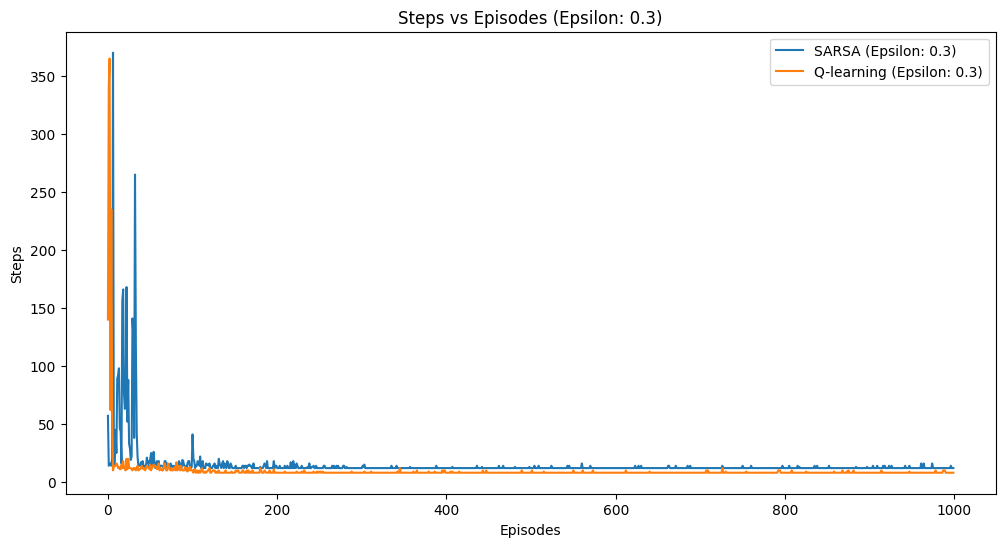

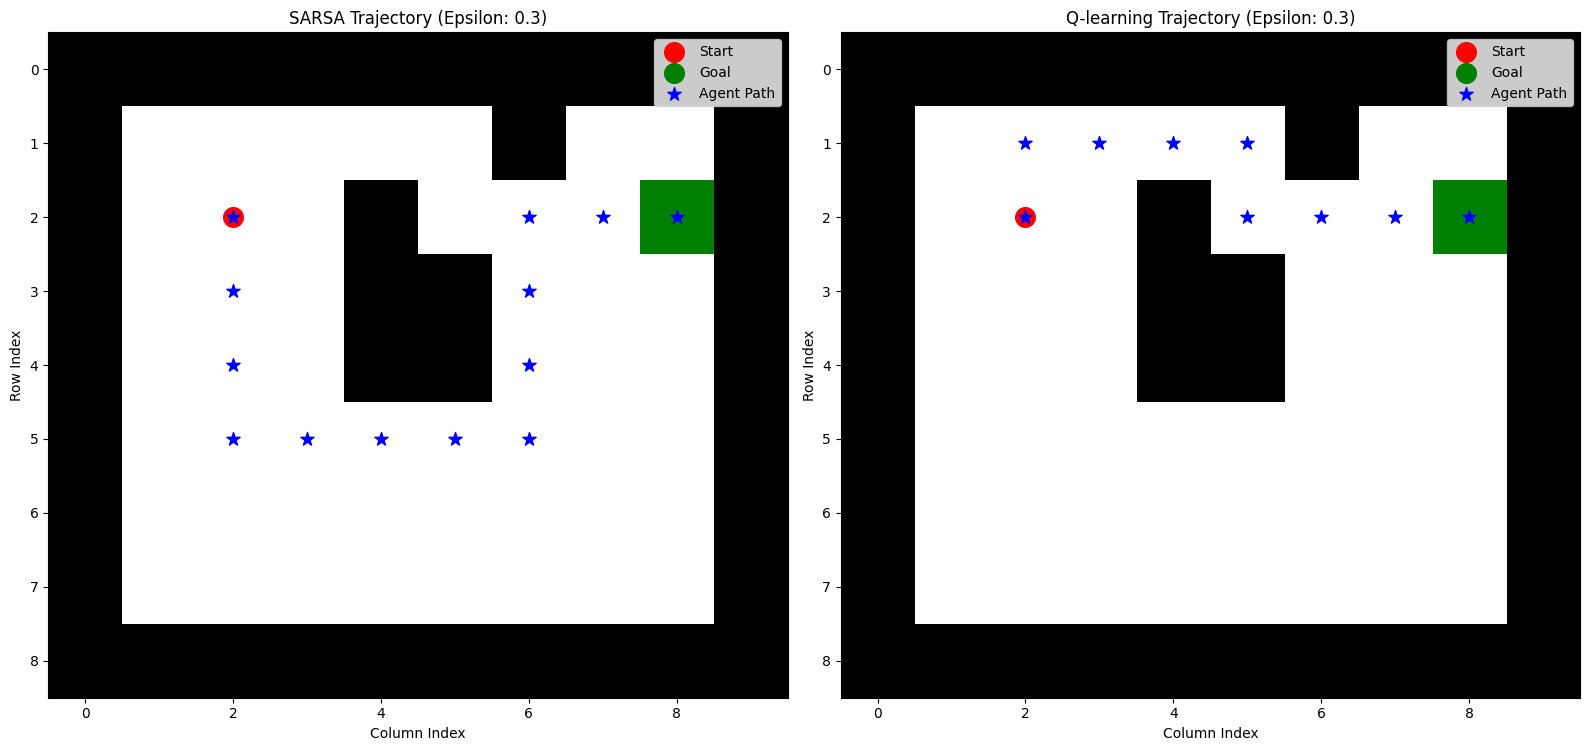

SARSA Learning Time: 0.05 seconds, Steps: 12, average reward 9.265
Q-learning Learning Time: 0.03 seconds, Steps: 8, average reward 8.37


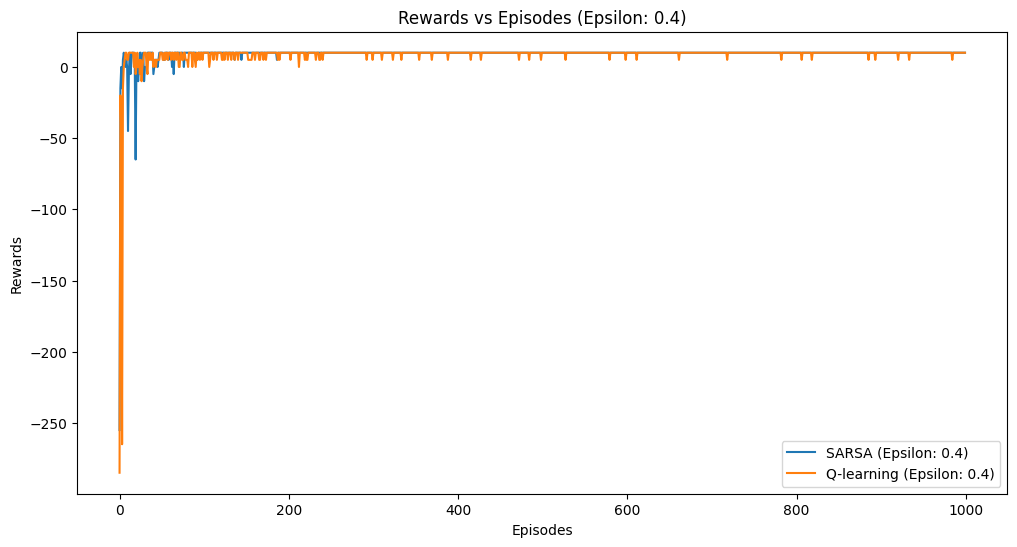

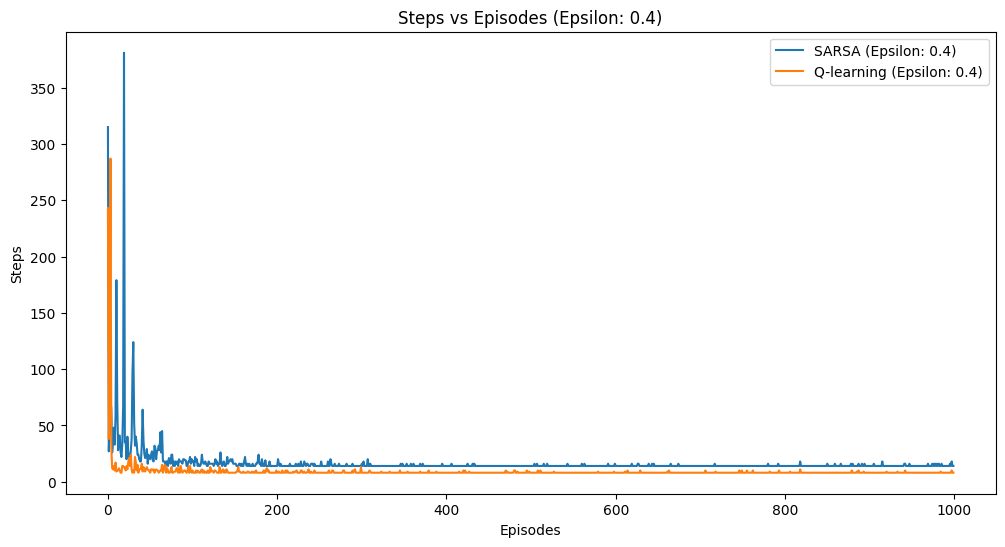

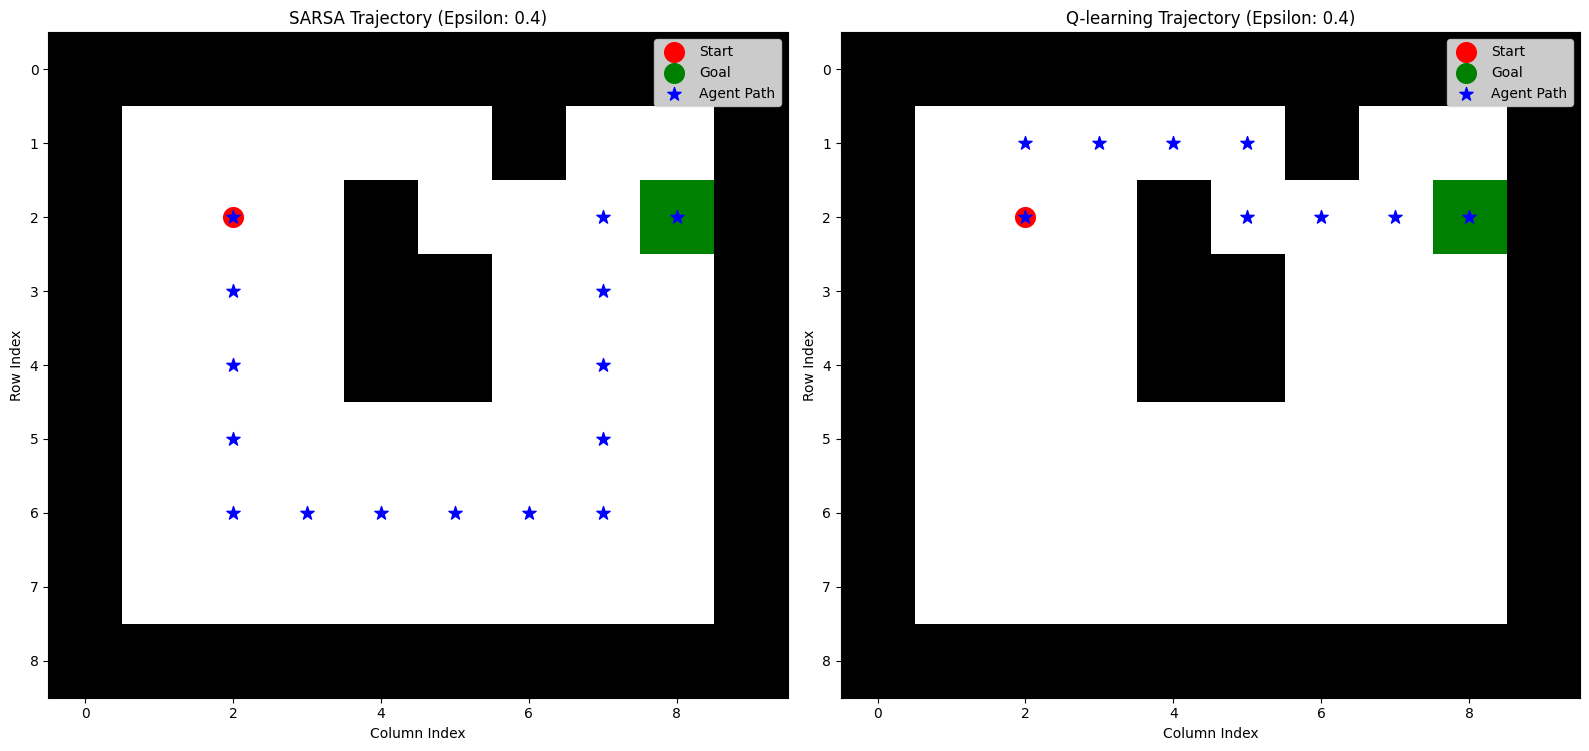

SARSA Learning Time: 0.05 seconds, Steps: 14, average reward 9.225
Q-learning Learning Time: 0.03 seconds, Steps: 8, average reward 8.665


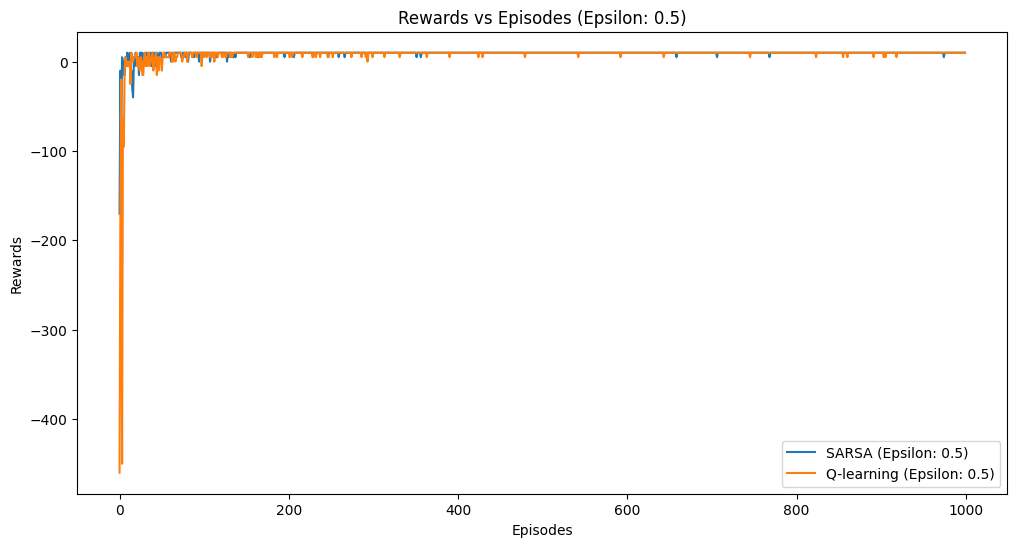

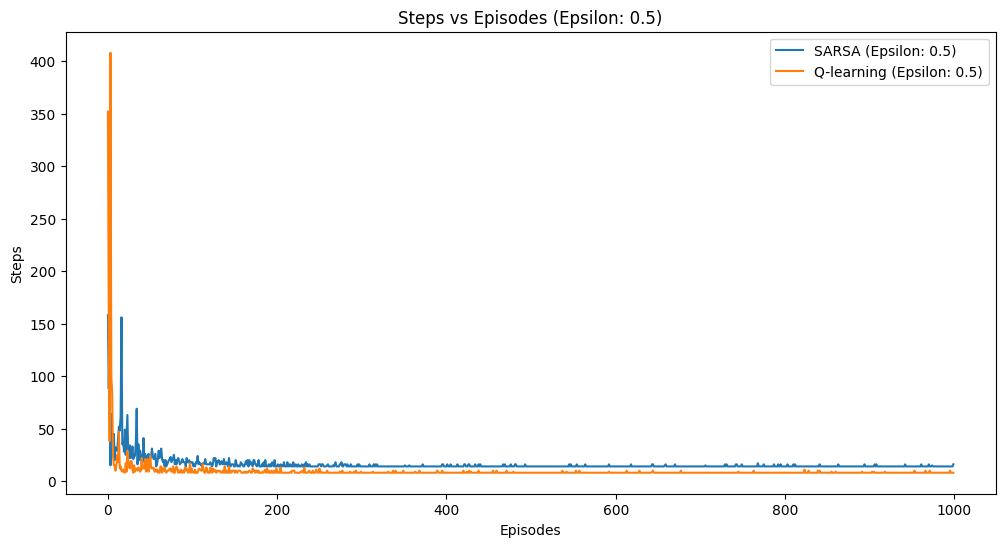

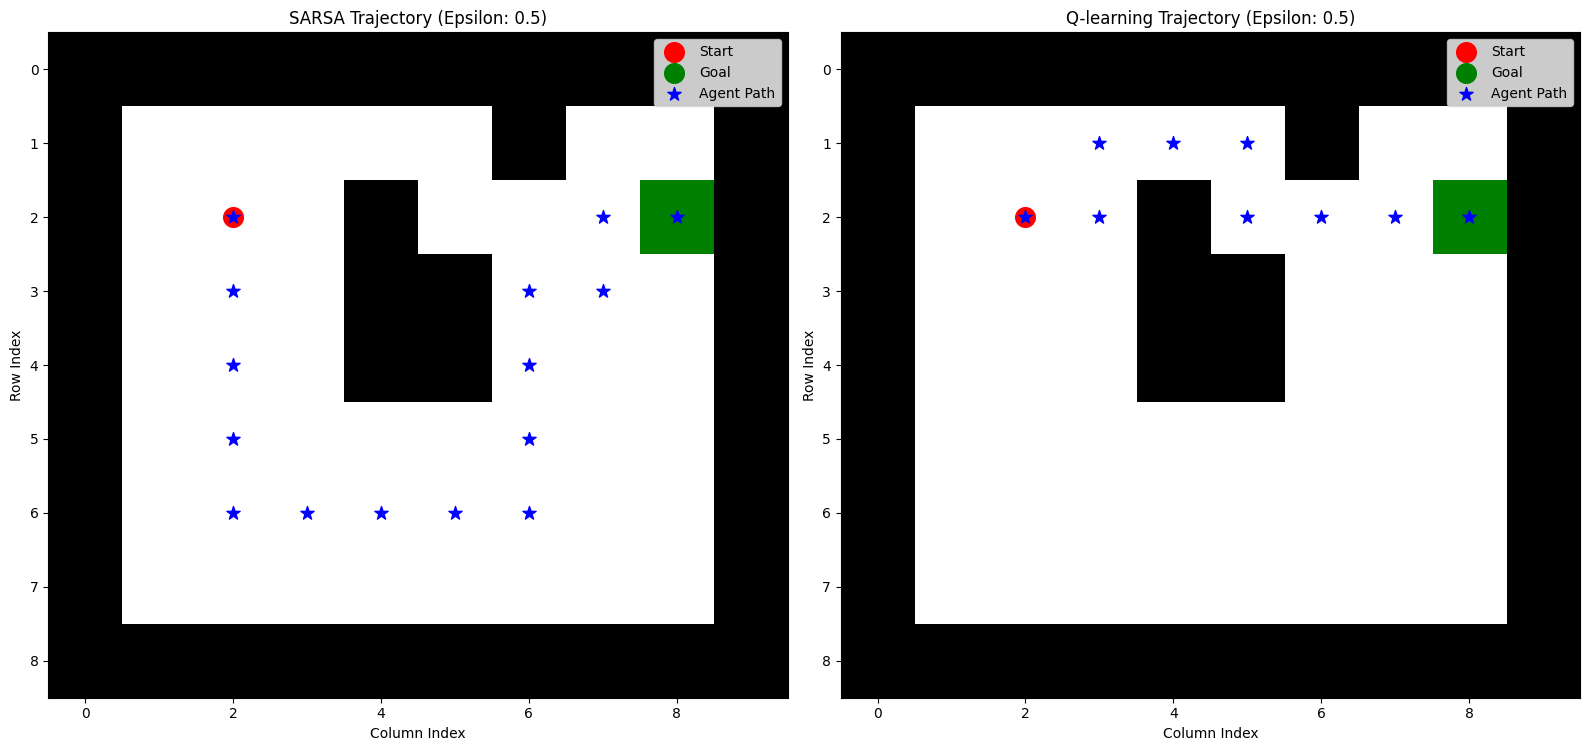

SARSA Learning Time: 0.05 seconds, Steps: 14, average reward 9.105
Q-learning Learning Time: 0.03 seconds, Steps: 8, average reward 7.82


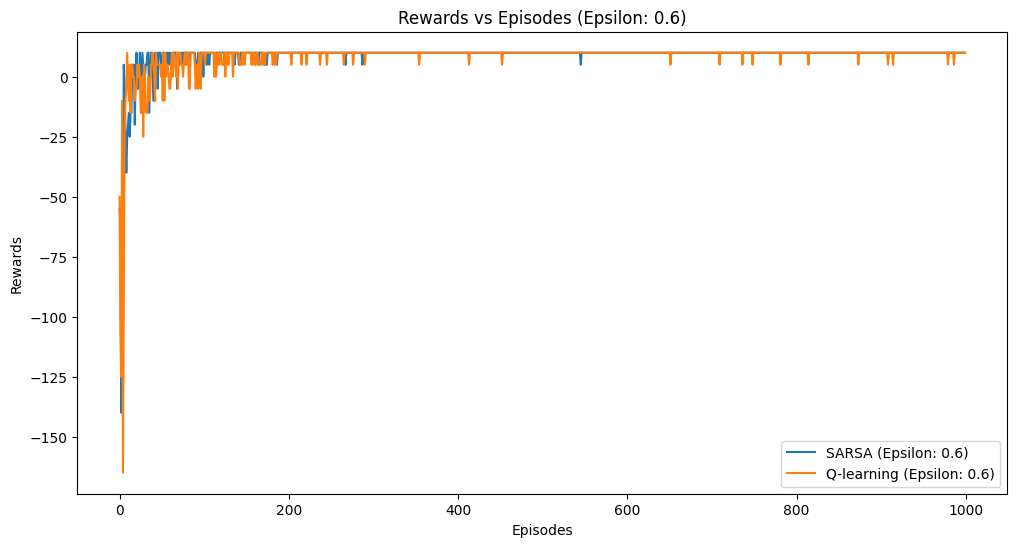

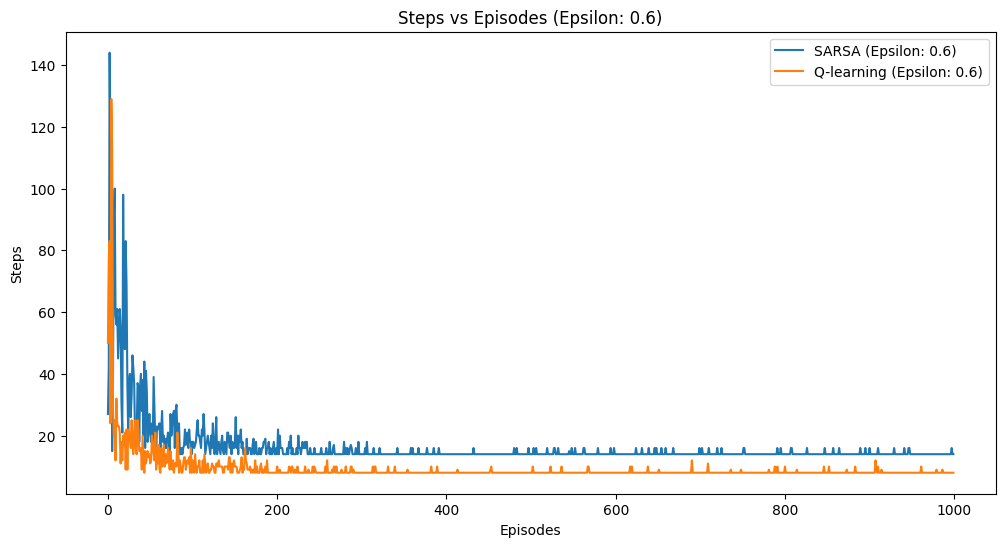

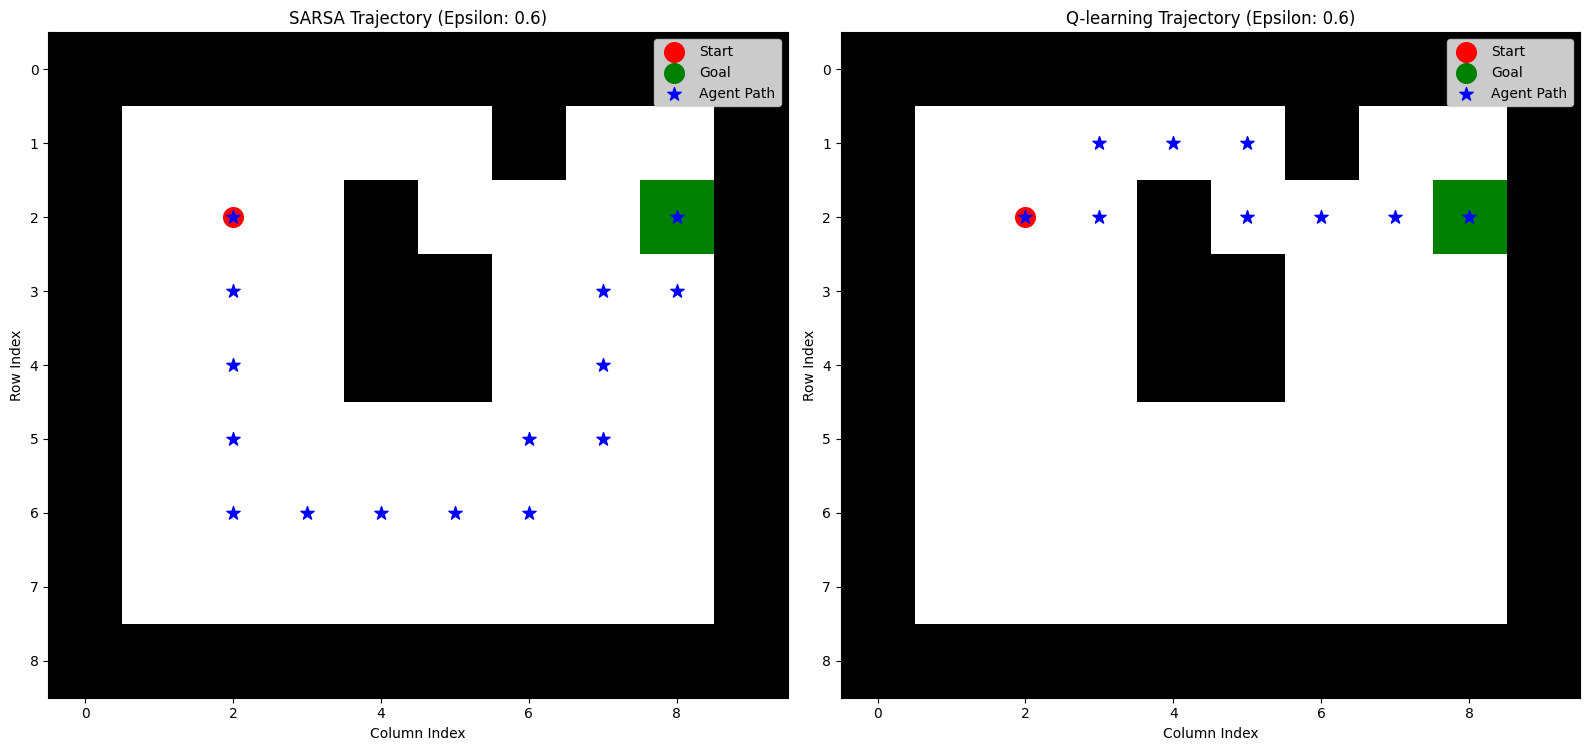

SARSA Learning Time: 0.05 seconds, Steps: 14, average reward 8.84
Q-learning Learning Time: 0.03 seconds, Steps: 8, average reward 8.27


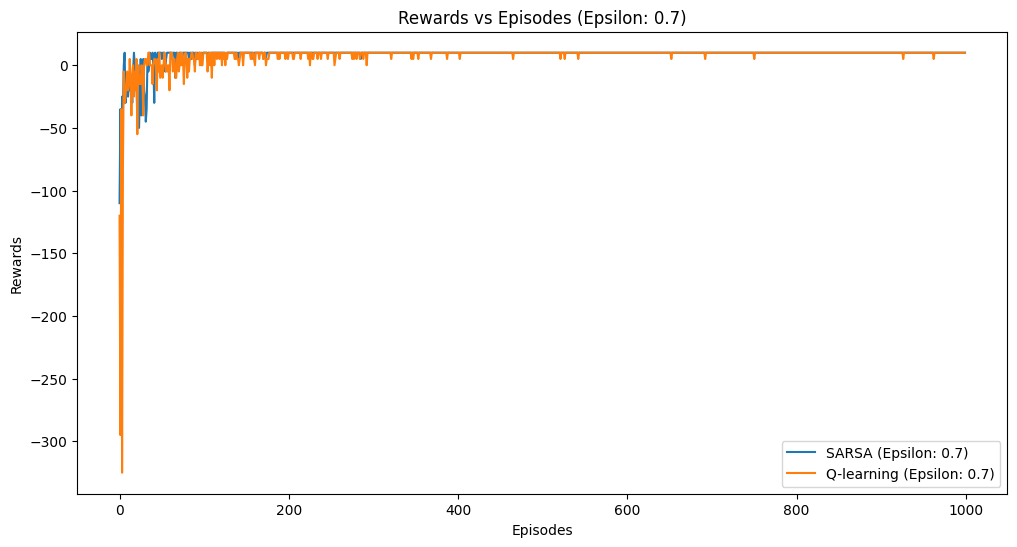

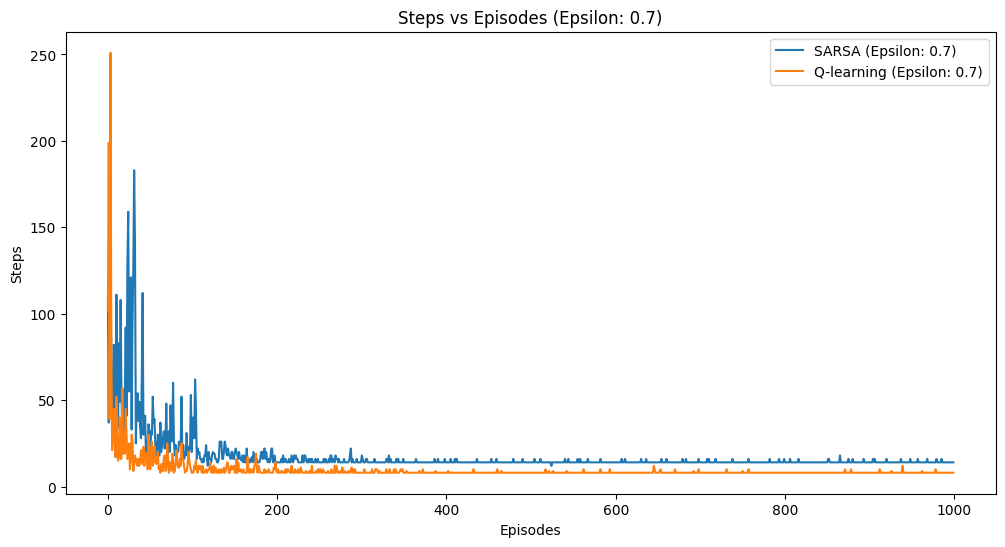

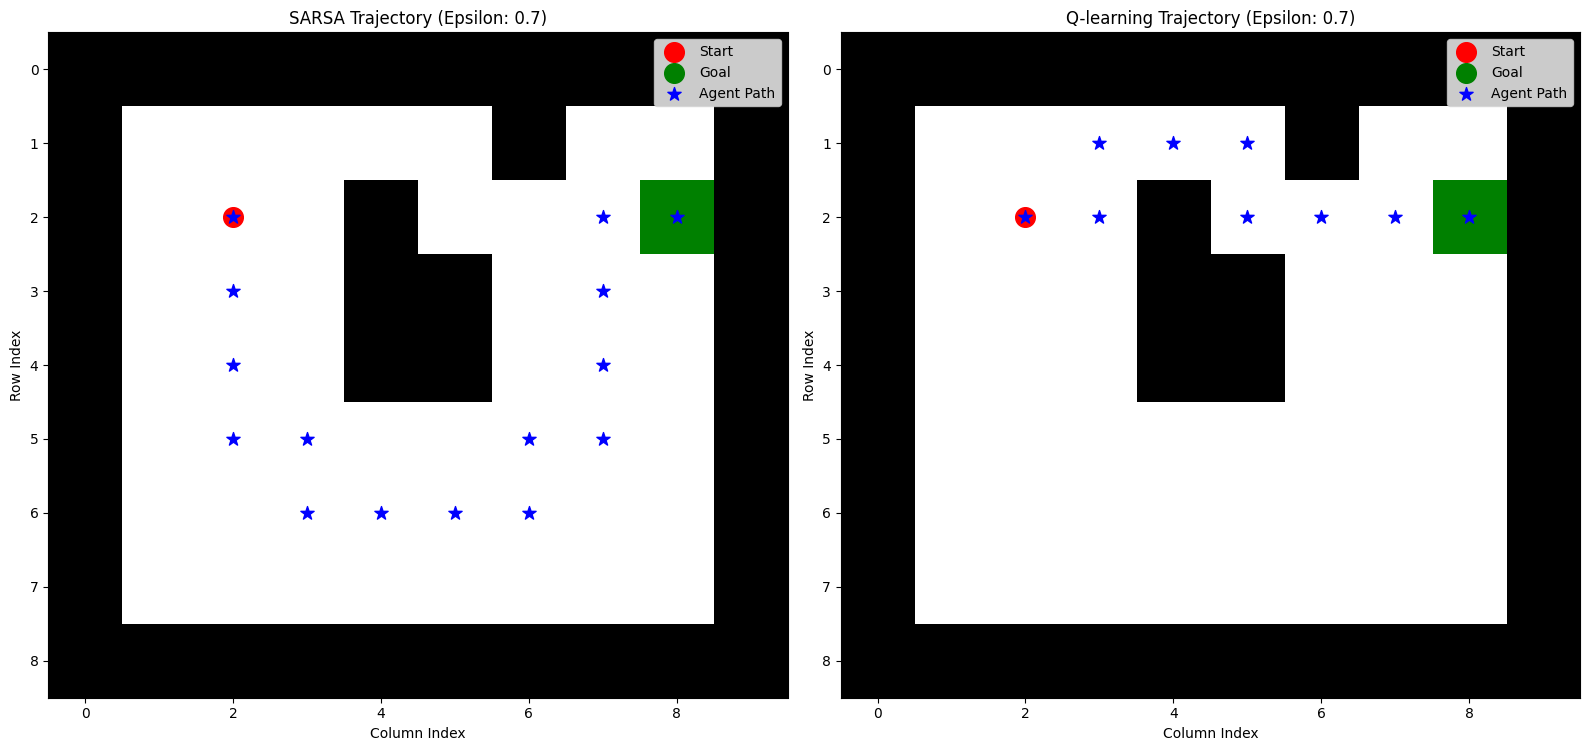

SARSA Learning Time: 0.05 seconds, Steps: 14, average reward 8.605
Q-learning Learning Time: 0.04 seconds, Steps: 8, average reward 7.485


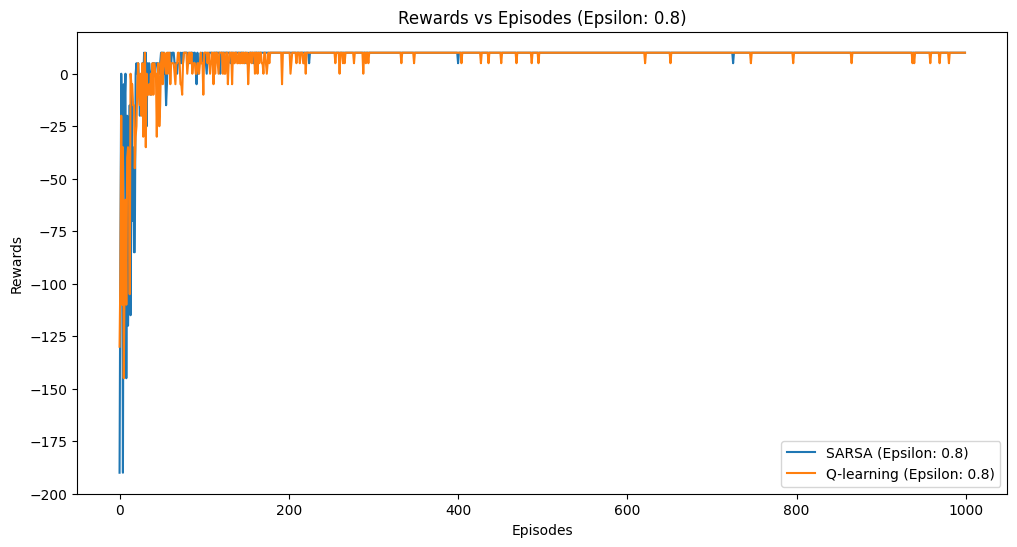

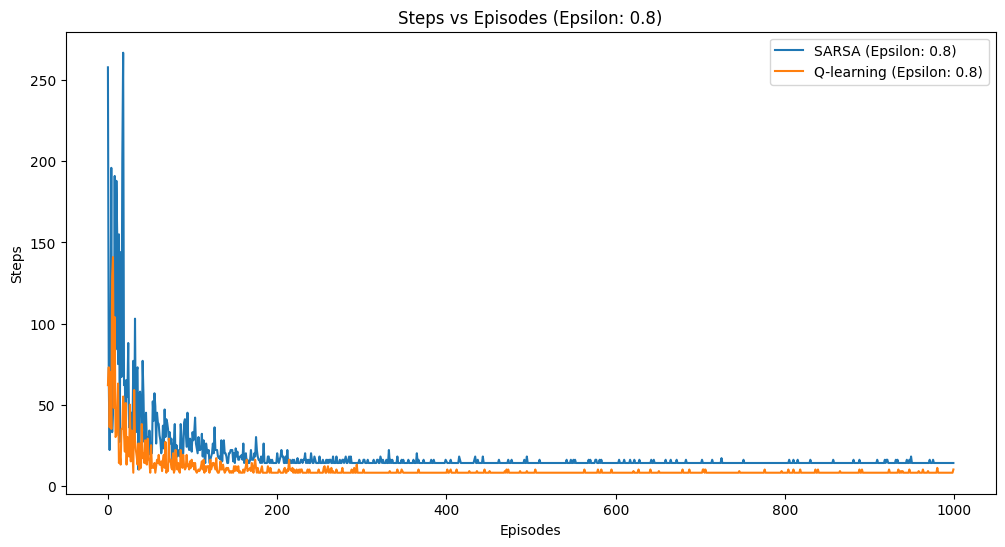

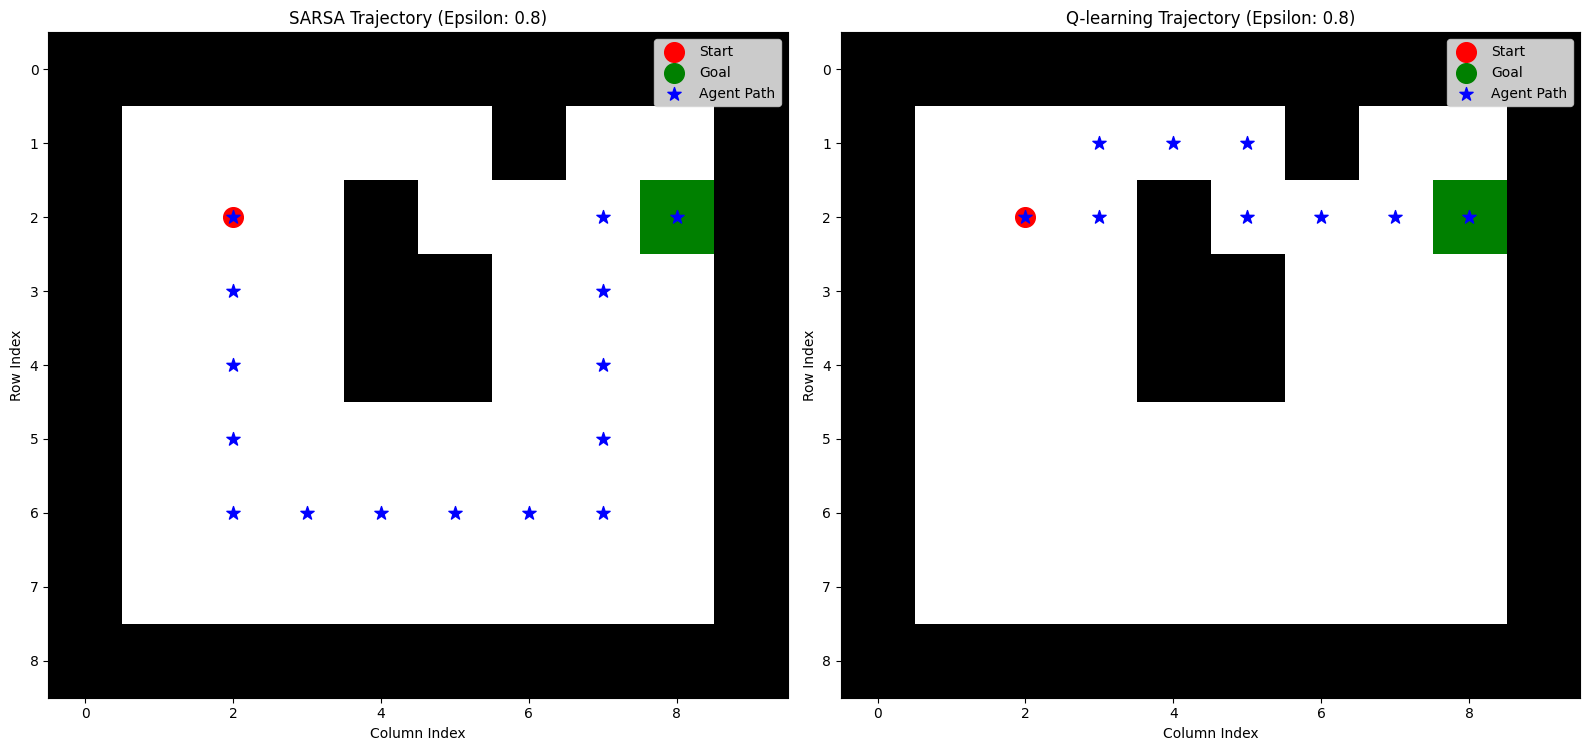

SARSA Learning Time: 0.06 seconds, Steps: 14, average reward 7.92
Q-learning Learning Time: 0.16 seconds, Steps: 8, average reward 7.37


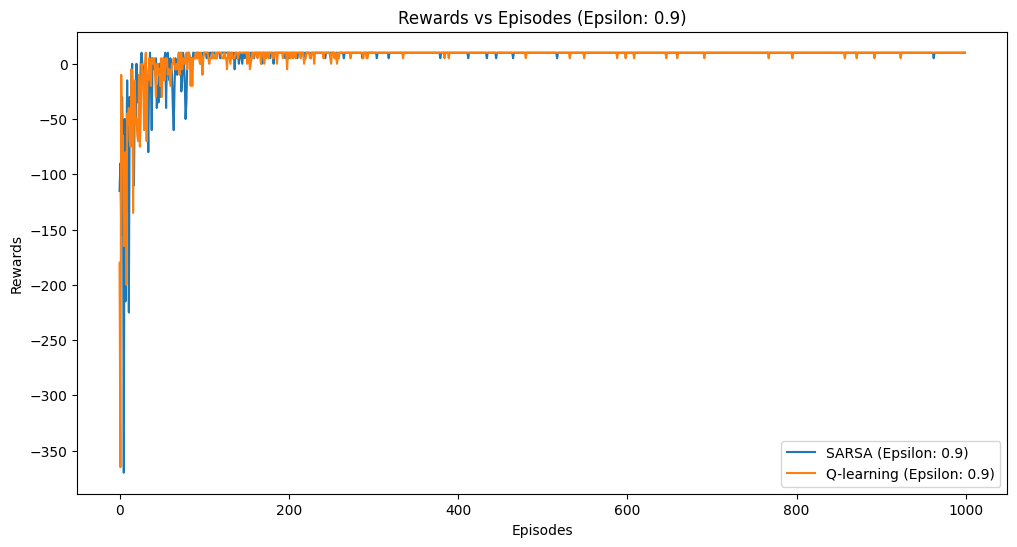

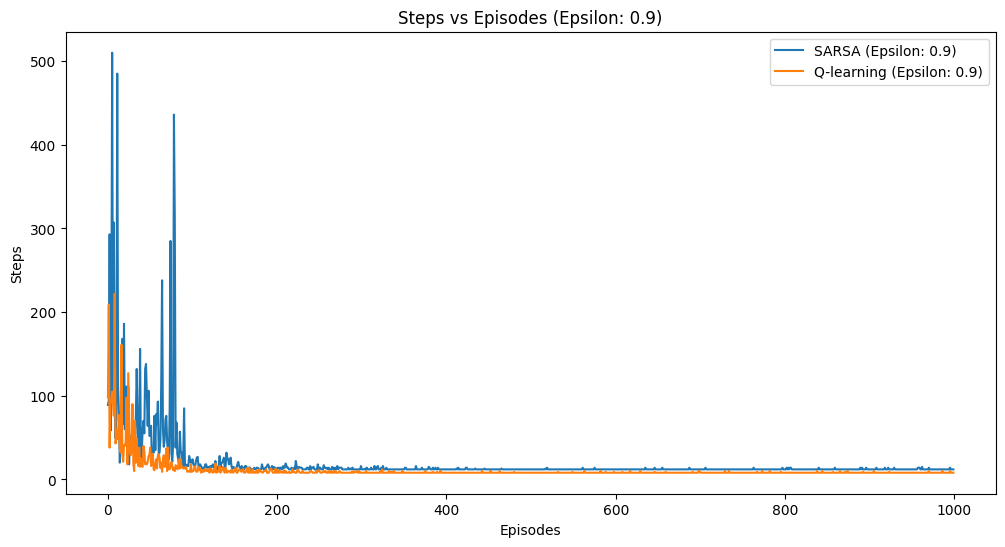

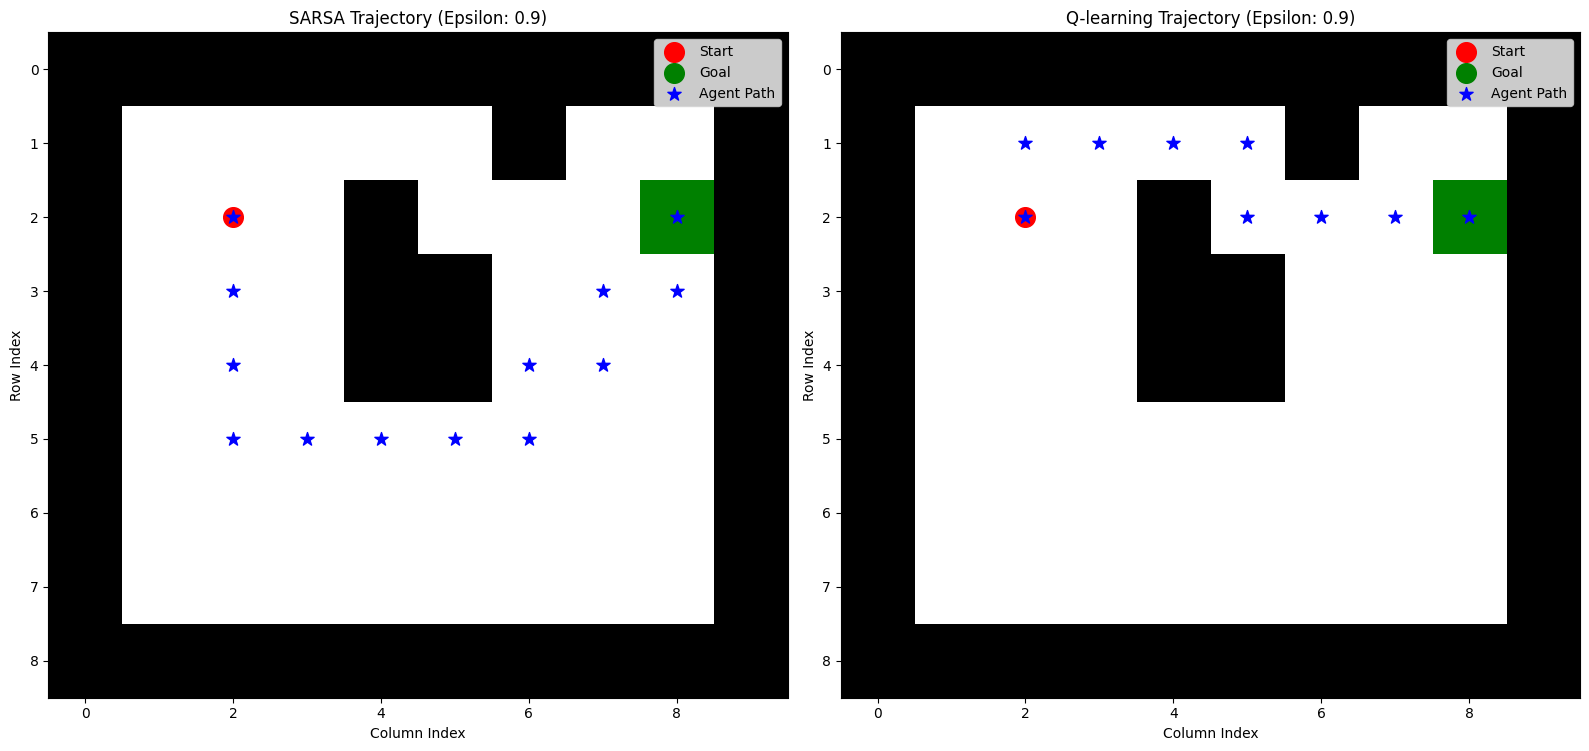

SARSA Learning Time: 0.07 seconds, Steps: 12, average reward 6.35
Q-learning Learning Time: 0.04 seconds, Steps: 8, average reward 6.12


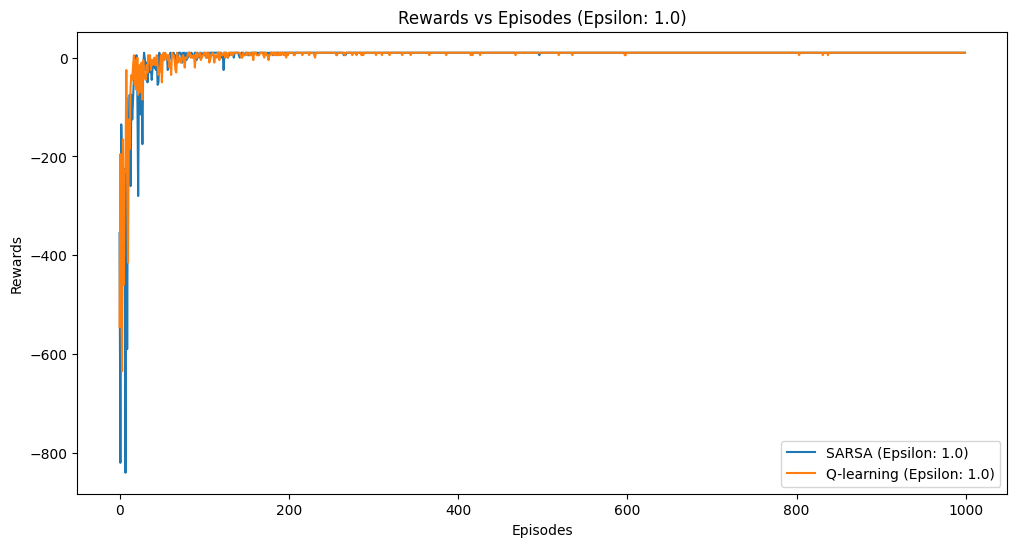

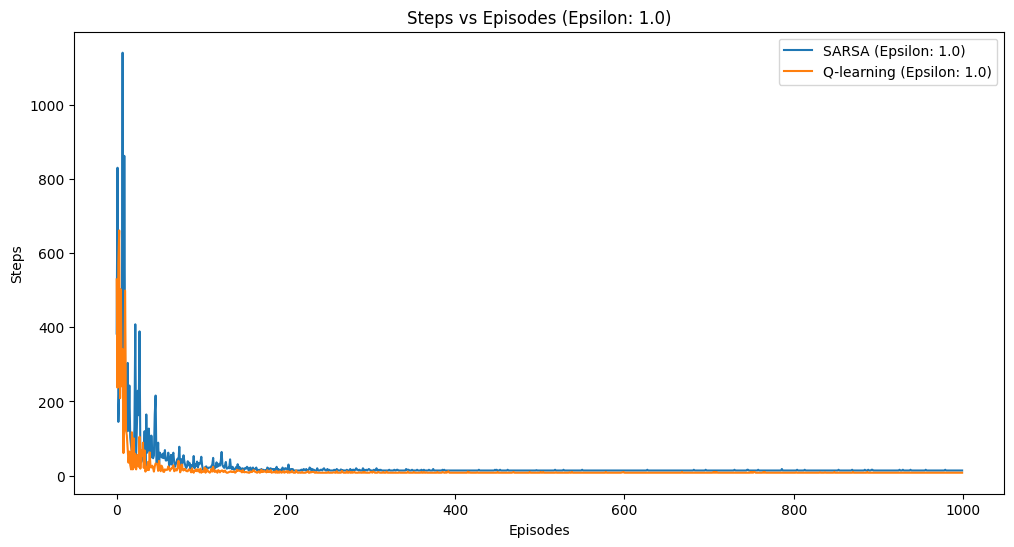

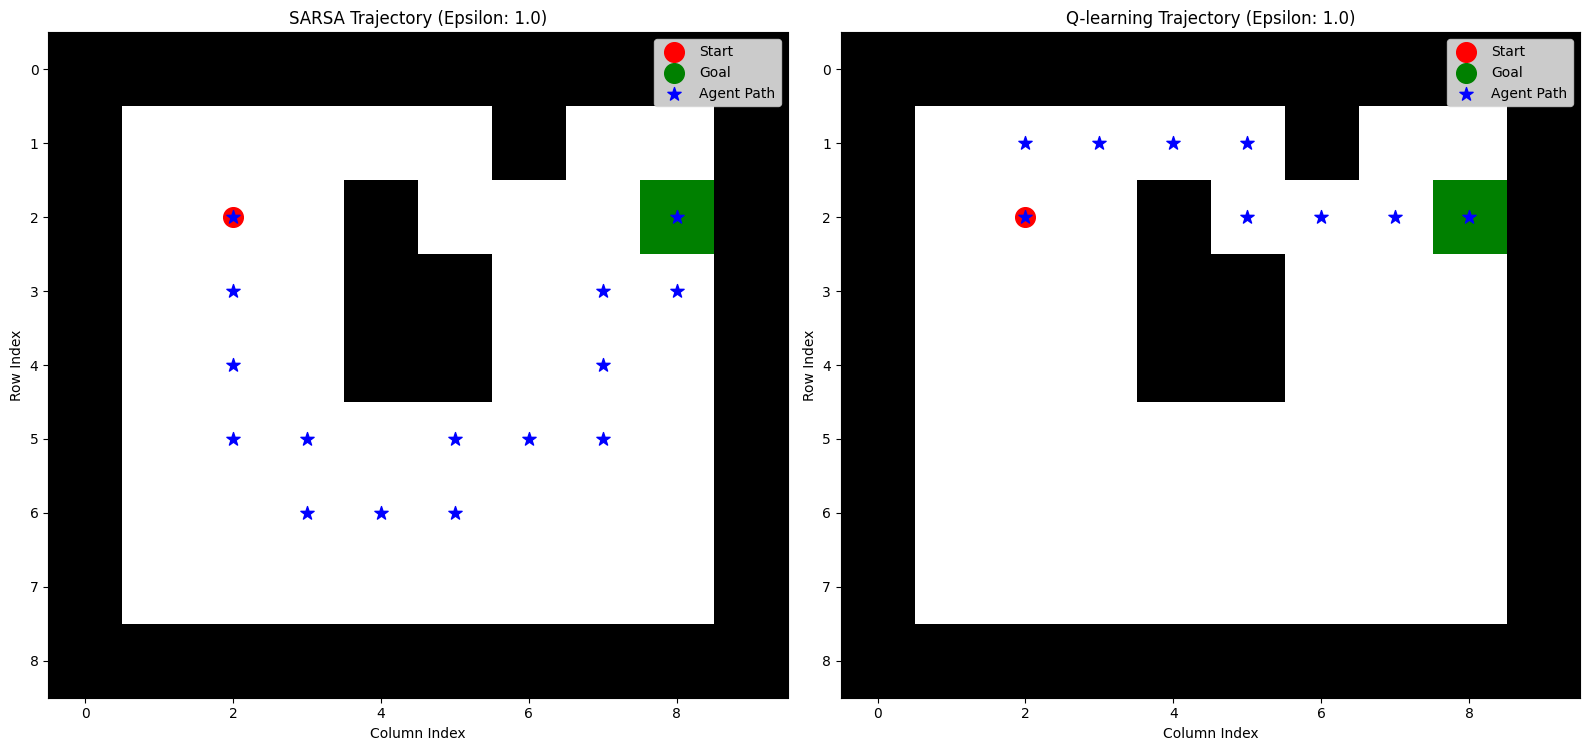

SARSA Learning Time: 0.07 seconds, Steps: 14, average reward 2.82
Q-learning Learning Time: 0.04 seconds, Steps: 8, average reward 3.52


In [12]:
for i, epsilon in enumerate(epsilon_values):

    plt.figure(figsize=(12, 6))
    plt.plot(all_rewards_sarsa[i], label=f'SARSA (Epsilon: {epsilon})')
    plt.plot(all_rewards_qlearning[i], label=f'Q-learning (Epsilon: {epsilon})')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.title(f'Rewards vs Episodes (Epsilon: {epsilon})')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(all_steps_sarsa[i], label=f'SARSA (Epsilon: {epsilon})')
    plt.plot(all_steps_qlearning[i], label=f'Q-learning (Epsilon: {epsilon})')
    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title(f'Steps vs Episodes (Epsilon: {epsilon})')
    plt.legend()
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    render_trajectory(SARSAgent(Grid_world_Env_Deterministic(), num_episodes=1000, epsilon=epsilon), all_trajectories_sarsa[i], epsilon, 'SARSA', axs[0])
    render_trajectory(QLearningAgent(Grid_world_Env_Deterministic(), num_episodes=1000, epsilon=epsilon), all_trajectories_qlearning[i], epsilon, 'Q-learning', axs[1])
    plt.tight_layout()
    plt.show()

    start_time = time.time()
    sarsa_agent = SARSAgent(Grid_world_Env_Deterministic(), num_episodes=1000, epsilon=epsilon)
    sarsa_trajectory = render_trajectory(sarsa_agent, all_trajectories_sarsa[i], epsilon, 'SARSA', axs[0])
    sarsa_time = time.time() - start_time
    sarsa_steps = len(sarsa_trajectory)-1

    start_time = time.time()
    qlearning_agent = QLearningAgent(Grid_world_Env_Deterministic(), num_episodes=1000, epsilon=epsilon)
    qlearning_trajectory = render_trajectory(qlearning_agent, all_trajectories_qlearning[i], epsilon, 'Q-learning', axs[1])
    qlearning_time = time.time() - start_time
    qlearning_steps = len(qlearning_trajectory)-1


    print(f"SARSA Learning Time: {sarsa_time:.2f} seconds, Steps: {sarsa_steps}, average reward {avg_rewards_sarsa[i]}")
    print(f"Q-learning Learning Time: {qlearning_time:.2f} seconds, Steps: {qlearning_steps}, average reward {avg_rewards_qlearning[i]}")

    print('===========================================================================================================================================================================================')

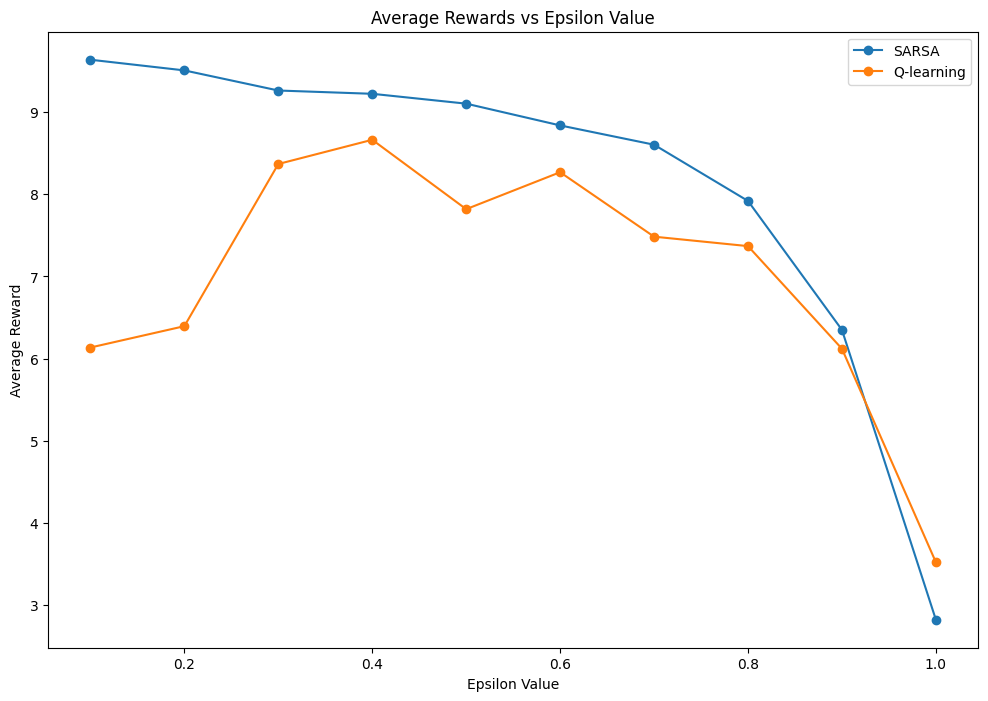

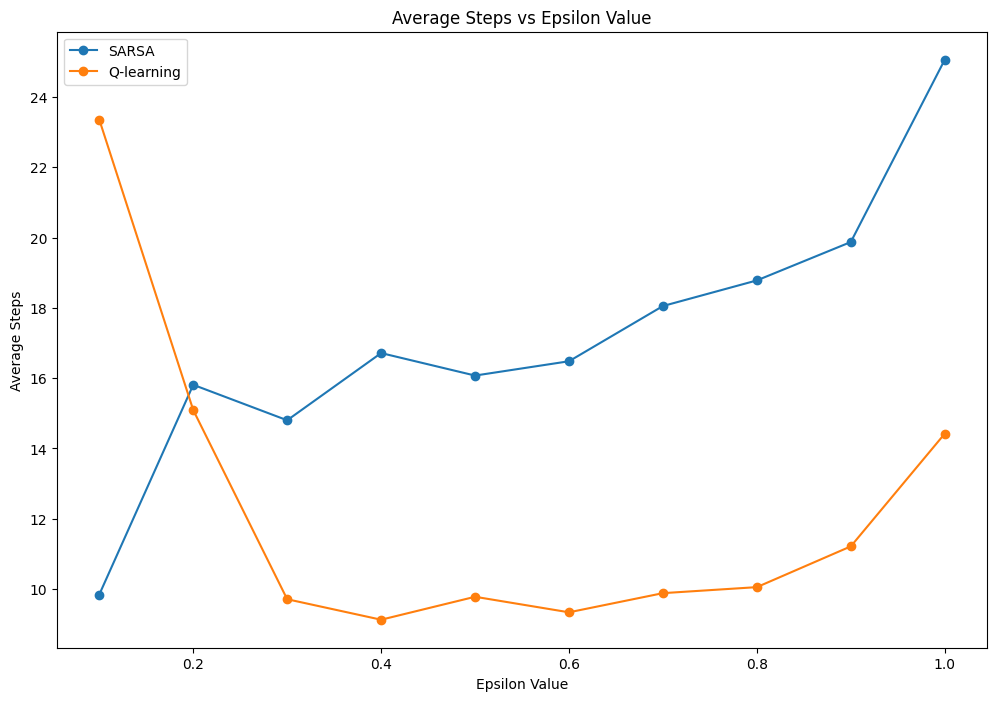

In [13]:
plot_results(avg_rewards_sarsa, avg_steps_sarsa, avg_rewards_qlearning, avg_steps_qlearning, epsilon_values)

##**Optimal value for epsilon**

In [15]:
optimal_epsilon_sarsa = epsilon_values[np.argmax(avg_rewards_sarsa)]
optimal_epsilon_qlearning = epsilon_values[np.argmax(avg_rewards_qlearning)]

print(f"Optimal epsilon for SARSA: {optimal_epsilon_sarsa}")
print(f"Optimal epsilon for Q-learning: {optimal_epsilon_qlearning}")


Optimal epsilon for SARSA: 0.1
Optimal epsilon for Q-learning: 0.4


In [16]:
optimal_epsilon_sarsa = epsilon_values[np.argmin(avg_steps_sarsa)]
optimal_epsilon_qlearning = epsilon_values[np.argmin(avg_steps_qlearning)]

print(f"Optimal epsilon for SARSA: {optimal_epsilon_sarsa}")
print(f"Optimal epsilon for Q-learning: {optimal_epsilon_qlearning}")

Optimal epsilon for SARSA: 0.1
Optimal epsilon for Q-learning: 0.4
